In [1]:
from valurap2 import path_planning, gcode

input_fn = "diplo.gcode"
seg_no = 18

#input_fn = "box20.gcode"
#seg_no = 18

lines = gcode.reader(input_fn)
pg = gcode.path_gen(lines)
sg = gcode.gen_segments(pg)
for i, s in enumerate(sg):
    if isinstance(s, gcode.do_segment):
        print("segment", i, len(s.path))
        
    if i == seg_no:
        break
        
print(s.path)

Extruder switch to 0
do_extruder
Do Home
do_home
Set current ['E0']
Set current ['E0']
Set current ['E0']
Set current ['E0']
segment 6 663
segment 8 6
segment 10 1659
segment 12 5
segment 14 1626
segment 16 7
segment 18 2270
[[-7.895, 16.607000000000003, 0, -237.33058, 4000], [-8.207, 15.999000000000004, 75.0, -237.36468, 4001], [-8.41, 15.525000000000004, 75.0, -237.3904, 4002], [-8.651, 14.981000000000003, 75.0, -237.42008, 4003], [-8.845, 14.466000000000003, 75.0, -237.44754, 4004], [-9.113, 13.924000000000003, 75.0, -237.47771, 4005], [-9.383, 13.431000000000003, 75.0, -237.50575, 4006], [-9.565, 13.016000000000004, 75.0, -237.52836, 4007], [-9.822, 12.419000000000004, 75.0, -237.56078, 4008], [-10.009, 11.952000000000004, 75.0, -237.58588, 4009], [-10.164, 11.530000000000003, 75.0, -237.60831, 4010], [-10.343, 10.961000000000004, 75.0, -237.63807, 4011], [-10.58, 10.343000000000004, 75.0, -237.67109, 4012], [-10.835, 9.794000000000004, 75.0, -237.70129, 4013], [-10.99, 9.390000000

In [2]:
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
from matplotlib import collections  as mc

%matplotlib notebook


path = np.array(s.path)

df = pd.DataFrame({"x": path[:, 0], "y": path[:, 1], "v": path[:,2]})
df["dx"] = df["x"] - df["x"].shift(1)
df["dy"] = df["y"] - df["y"].shift(1)
df["next_dx"] = df["dx"].shift(-1)
df["next_dy"] = df["dy"].shift(-1)
df["d"] = np.linalg.norm([df["dx"], df["dy"]], axis=0)
df["dt"] = df["d"] / df["v"]

if 0:
    def add_angle(df):
        df["angle"] = 180 - np.arccos((df["dx"]*df["next_dx"] + df["dy"]*df["next_dy"])/np.linalg.norm([df["dx"], df["dy"]], axis=0)/np.linalg.norm([df["next_dx"], df["next_dy"]], axis=0)) * 180 / math.pi

    def add_circle(df):
        x1 = df["x"].shift(1)
        y1 = df["y"].shift(1)
        x2 = df["x"]
        y2 = df["y"]
        x3 = df["x"].shift(-1)
        y3 = df["y"].shift(-1)

        x12 = x1 - x2;  
        x13 = x1 - x3;  

        y12 = y1 - y2;  
        y13 = y1 - y3;  

        y31 = y3 - y1;  
        y21 = y2 - y1;  

        x31 = x3 - x1;  
        x21 = x2 - x1;  

        sx13 = x1 * x1 - x3 * x3 
        sy13 = y1 * y1 - y3 * y3  

        sx21 = x2 * x2 - x1 * x1;  
        sy21 = y2 * y2 - y1 * y1;  

        f = (sx13 * x12 + sy13 * x12 + sx21 * x13 + sy21 * x13) / (2 * (y31 * x12 - y21 * x13))              
        g = (sx13 * y12 + sy13 * y12 + sx21 * y13 + sy21 * y13) / (2 * (x31 * y12 - x21 * y13))
        c = -x1 * x1 - y1 * y1 - 2 * g * x1 - 2 * f * y1

        cx = -g 
        cy = -f

        r = np.sqrt(cx * cx + cy * cy - c)

        v1x = x1 - cx
        v2x = x2 - cx
        v3x = x3 - cx

        v1y = y1 - cy
        v2y = y2 - cy
        v3y = y3 - cy

        v12x = (v1x + v2x) / 2
        v12y = (v1y + v2y) / 2
        d12 = r - np.linalg.norm([v12x, v12y], axis=0)
        p12x = cx + v12x / (r - d12) * r
        p12y = cy + v12y / (r - d12) * r

        v23x = (v2x + v3x) / 2
        v23y = (v2y + v3y) / 2
        d23 = r - np.linalg.norm([v23x, v23y], axis=0)
        p23x = cx + v23x / (r - d23) * r
        p23y = cy + v23y / (r - d23) * r

        df["r"] = r
        df["cx"] = cx
        df["cy"] = cy
        df["d12"] = d12
        df["d23"] = d23
        df["p12x"] = p12x
        df["p12y"] = p12y
        df["p23x"] = p23x
        df["p23y"] = p23y

    add_angle(df)
    add_circle(df)

    sdf = df[20:-20]
    lines = []
    colors = []
    for l in sdf.iterrows():
        l = l[1]
        lines.append(((l.x, l.y),(l.cx, l.cy)))
        colors.append([0,1,0])
        lines.append(((l.cx, l.cy),(l.p12x, l.p12y)))
        colors.append([1,0,0])
        lines.append(((l.cx, l.cy),(l.p23x, l.p23y)))
        colors.append([1,1,0])

    lc = mc.LineCollection(lines, colors=colors, linewidths=1)

    display(sdf)
    ax = sdf.plot(x="x", y="y", style=".-")
    ax.add_collection(lc)


    plt.axis("square")


    #display(p.ax)

In [89]:
pp = path_planning.PathPlanner()
path = s.path
path, slowdowns = pp.make_path(path)
slowdowns, updated, cc = pp.process_corner_errors(path, slowdowns)
slowdowns, updated = pp.reverse_pass(path, slowdowns)
slowdowns, updated = pp.forward_pass(path, slowdowns)
_, updated = pp.forward_pass(path, slowdowns)

assert updated == 0

speeds = pp.gen_speeds(path, slowdowns)
_, _, cc = pp.process_corner_errors(path, slowdowns)

plato = pd.DataFrame()
plato["middle_x"] = path["px"] + cc["mdx"]
plato["middle_y"] = path["py"] + cc["mdy"]
plato["middle_e"] = path["pe"]
plato["middle_vx"] = cc["mvx"]
plato["middle_vy"] = cc["mvy"]
plato["middle_v"] = np.linalg.norm(cc[["mvx", "mvy"]], axis=1)

plato["start_x"] = path["px"] + speeds["unit_x"] * cc["l_entry"]
plato["start_y"] = path["py"] + speeds["unit_y"] * cc["l_entry"]
plato["start_e"] = path["pe"] + speeds["unit_e"] * cc["l_entry"]
plato["start_vx"] = speeds["entry_x"]
plato["start_vy"] = speeds["entry_y"]
plato["start_v"] = speeds["entry"]
plato["top_vx"] = speeds["plato_x"]
plato["top_vy"] = speeds["plato_y"]
plato["top_v"] = speeds["plato"]
plato["end_x"] = path["x"] - speeds["unit_x"] * cc["l_exit"]
plato["end_y"] = path["y"] - speeds["unit_y"] * cc["l_exit"]
plato["end_e"] = path["e"] - speeds["unit_e"] * cc["l_exit"]
plato["end_vx"] = speeds["exit_x"]
plato["end_vy"] = speeds["exit_y"]
plato["end_v"] = speeds["exit"]
plato["v_to_ve"] = speeds["v_to_ve"]

plato["pre_x"] = plato["end_x"].shift(1).fillna(path["px"][0])
plato["pre_y"] = plato["end_y"].shift(1).fillna(path["py"][0])
plato["pre_e"] = plato["end_e"].shift(1).fillna(0)
plato["pre_vx"] = plato["end_vx"].shift(1).fillna(0)
plato["pre_vy"] = plato["end_vy"].shift(1).fillna(0)
plato["pre_v"] = plato["end_v"].shift(1).fillna(0)
plato["pre_v_to_ve"] = plato["v_to_ve"].shift(1).fillna(0)
plato["corner_dt"] = cc["dt"]

plato["plato_l"] = cc["l_free"]
plato["max_top_v"] = np.sqrt(2 * speeds["max_a"] * 0.9 * plato["plato_l"] + pow(plato["start_v"], 2) + pow(plato["end_v"], 2)) / np.sqrt(2)

assert all(plato["max_top_v"] >= plato["start_v"])
assert all(plato["max_top_v"] >= plato["end_v"])

plato["real_top_v"] = np.min(plato[["top_v", "max_top_v"]], axis=1)
plato["real_top_vx"] = plato["real_top_v"] * speeds["unit_x"]
plato["real_top_vy"] = plato["real_top_v"] * speeds["unit_y"]
plato["accel_dt"] = (plato["real_top_v"] - plato["start_v"]) / speeds["max_a"]
plato["decel_dt"] = (plato["real_top_v"] - plato["end_v"]) / speeds["max_a"]
plato["accel_l"] = (plato["real_top_v"] + plato["start_v"]) * plato["accel_dt"] / 2
plato["decel_l"] = (plato["real_top_v"] + plato["end_v"]) * plato["decel_dt"] / 2
plato["top_l"] = plato["plato_l"] - plato["accel_l"] - plato["decel_l"]
plato["top_dt"] = (plato["top_l"] / plato["real_top_v"]).fillna(0)
plato["dt"] = plato["corner_dt"] + plato["accel_dt"] + plato["top_dt"] + plato["decel_dt"]
plato["t"] = np.cumsum(plato["dt"]).shift(1).fillna(0)
#display(plato)
#display(plato.iloc[0])
#display(plato.iloc[1])
#display(plato.iloc[-2])
#display(plato.iloc[-1])

pre_corner_segs = pd.DataFrame()
pre_corner_segs["idx"] = plato.index.values * 5
pre_corner_segs["tp"] = 0
pre_corner_segs["line"] = path["line"]
pre_corner_segs["t"] = plato["t"]

dt = plato["corner_dt"] / 2
dt[0] = 0
dt[len(dt) - 1] *= 2 
pre_corner_segs["dt"] = dt

pre_corner_segs["start_x"] = plato["pre_x"]
pre_corner_segs["start_y"] = plato["pre_y"]
pre_corner_segs["start_e"] = plato["pre_e"]
pre_corner_segs["start_vx"] = plato["pre_vx"]
pre_corner_segs["start_vy"] = plato["pre_vy"]
pre_corner_segs["end_x"] = plato["middle_x"]
pre_corner_segs["end_y"] = plato["middle_y"]
pre_corner_segs["end_e"] = plato["middle_e"]
pre_corner_segs["end_vx"] = plato["middle_vx"]
pre_corner_segs["end_vy"] = plato["middle_vy"]
pre_corner_segs["v_to_ve"] = plato["pre_v_to_ve"]

corner_segs = pd.DataFrame()
corner_segs["idx"] = pre_corner_segs["idx"] + 1
corner_segs["tp"] = 1
corner_segs["line"] = path["line"]
corner_segs["t"] = pre_corner_segs["t"] + pre_corner_segs["dt"]

dt = plato["corner_dt"] / 2
dt[0] *= 2
dt[len(dt) - 1] = 0 
corner_segs["dt"] = dt

corner_segs["start_x"] = pre_corner_segs["end_x"]
corner_segs["start_y"] = pre_corner_segs["end_y"]
corner_segs["start_e"] = pre_corner_segs["end_e"]
corner_segs["start_vx"] = pre_corner_segs["end_vx"]
corner_segs["start_vy"] = pre_corner_segs["end_vy"]
corner_segs["end_x"] = plato["start_x"]
corner_segs["end_y"] = plato["start_y"]
corner_segs["end_e"] = plato["start_e"]
corner_segs["end_vx"] = plato["start_vx"]
corner_segs["end_vy"] = plato["start_vy"]
corner_segs["v_to_ve"] = plato["v_to_ve"]

accel_segs = pd.DataFrame()
accel_segs["idx"] = corner_segs["idx"] + 1
accel_segs["tp"] = 2
accel_segs["line"] = path["line"]
accel_segs["t"] = corner_segs["t"] + corner_segs["dt"]
accel_segs["dt"] = plato["accel_dt"]
accel_segs["start_x"] = corner_segs["end_x"]
accel_segs["start_y"] = corner_segs["end_y"]
accel_segs["start_e"] = corner_segs["end_e"]
accel_segs["start_vx"] = corner_segs["end_vx"]
accel_segs["start_vy"] = corner_segs["end_vy"]
accel_segs["end_x"] = accel_segs["start_x"] + speeds["unit_x"] * plato["accel_l"]
accel_segs["end_y"] = accel_segs["start_y"] + speeds["unit_y"] * plato["accel_l"]
accel_segs["end_e"] = accel_segs["start_e"] + speeds["unit_e"] * plato["accel_l"]
accel_segs["end_vx"] = plato["real_top_vx"]
accel_segs["end_vy"] = plato["real_top_vy"]
accel_segs["v_to_ve"] = plato["v_to_ve"]

top_segs = pd.DataFrame()
top_segs["idx"] = accel_segs["idx"] + 1
top_segs["tp"] = 3
top_segs["line"] = path["line"]
top_segs["t"] = accel_segs["t"] + accel_segs["dt"]
top_segs["dt"] = plato["top_dt"]
top_segs["start_x"] = accel_segs["end_x"]
top_segs["start_y"] = accel_segs["end_y"]
top_segs["start_e"] = accel_segs["end_e"]
top_segs["start_vx"] = accel_segs["end_vx"]
top_segs["start_vy"] = accel_segs["end_vy"]
top_segs["end_x"] = top_segs["start_x"] + speeds["unit_x"] * plato["top_l"]
top_segs["end_y"] = top_segs["start_y"] + speeds["unit_y"] * plato["top_l"]
top_segs["end_e"] = top_segs["start_e"] + speeds["unit_e"] * plato["top_l"]
top_segs["end_vx"] = top_segs["start_vx"]
top_segs["end_vy"] = top_segs["start_vy"]
top_segs["v_to_ve"] = plato["v_to_ve"]

decel_segs = pd.DataFrame()
decel_segs["idx"] = top_segs["idx"] + 1
decel_segs["tp"] = 4
decel_segs["line"] = path["line"]
decel_segs["t"] = top_segs["t"] + top_segs["dt"]
decel_segs["dt"] = plato["decel_dt"]
decel_segs["start_x"] = top_segs["end_x"]
decel_segs["start_y"] = top_segs["end_y"]
decel_segs["start_e"] = top_segs["end_e"]
decel_segs["start_vx"] = top_segs["end_vx"]
decel_segs["start_vy"] = top_segs["end_vy"]
decel_segs["end_x"] = plato["end_x"]
decel_segs["end_y"] = plato["end_y"]
decel_segs["end_e"] = plato["end_e"]
decel_segs["end_vx"] = plato["end_vx"]
decel_segs["end_vy"] = plato["end_vy"]
decel_segs["v_to_ve"] = plato["v_to_ve"]

pre_corner_segs = pre_corner_segs.set_index("idx")
corner_segs = corner_segs.set_index("idx")
accel_segs = accel_segs.set_index("idx")
top_segs = top_segs.set_index("idx")
decel_segs = decel_segs.set_index("idx")

all_segs_raw = pd.concat([pre_corner_segs, corner_segs, accel_segs, top_segs, decel_segs]).sort_index()
all_segs_filter = (all_segs_raw["dt"] > 1e-5).values
all_segs_filter[0] = True
all_segs_filter[-1] = True
all_segs = all_segs_raw[all_segs_filter][[
    "tp", "line", "t", "v_to_ve", "start_x", "start_y", "start_e", "start_vx", "start_vy",
]].copy().sort_index()

all_segs["start_v"] = np.linalg.norm(all_segs[["start_vx", "start_vy"]], axis = 1)
all_segs["end_x"] = all_segs["start_x"].shift(-1)
all_segs["end_y"] = all_segs["start_y"].shift(-1)
all_segs["end_e"] = all_segs["start_e"].shift(-1)
all_segs["end_vx"] = all_segs["start_vx"].shift(-1)
all_segs["end_vy"] = all_segs["start_vy"].shift(-1)
all_segs["end_v"] = all_segs["start_v"].shift(-1)
all_segs["dt"] = all_segs["t"].shift(-1) - all_segs["t"]

all_segs = all_segs.iloc[1:-1,:]

all_segs["avg_v"] = (all_segs["start_v"] + all_segs["end_v"]) / 2

de = all_segs["end_e"] - all_segs["start_e"]
de[np.abs(de) < 1e-5] = 0
avg_ve = de / all_segs["dt"]

all_segs["dx"] = np.abs(80 * (all_segs["end_x"] - all_segs["start_x"]))
all_segs["dy"] = np.abs(80 * (all_segs["end_y"] - all_segs["start_y"]))
all_segs["de"] = np.abs(837 * de)
all_segs["dx_dt"] = all_segs["dt"] / all_segs["dx"] * 1000000
all_segs["dy_dt"] = all_segs["dt"] / all_segs["dy"] * 1000000
all_segs["de_dt"] = all_segs["dt"] / all_segs["de"] * 1000000
all_segs["avg_ve"] = avg_ve
all_segs["v_to_ve2"] = (all_segs["avg_ve"] / all_segs["avg_v"]).fillna(0)

all_segs                                  
            

cc updated 1271
rp updated: 1247
fp updated: 633


,tp,line,t,v_to_ve,start_x,start_y,start_e,start_vx,start_vy,start_v,...,dt,avg_v,dx,dy,de,dx_dt,dy_dt,de_dt,avg_ve,v_to_ve2
idx,,,,,,,,,,,,,,,,,,,,,
1,1,4001,0.000000,-0.049899,-7.895000,16.607000,0.000000,0.000000,0.000000,0.000000,...,0.019178,10.777647,7.549214,14.711288,8.632508,2540.350491,1303.600910,2221.561724,-0.537794,-0.049899
2,2,4001,0.019178,-0.049899,-7.989365,16.423109,-0.010314,-9.841162,-19.177648,21.555293,...,0.010395,27.396915,10.401331,20.269261,11.893898,999.346087,512.822334,873.938074,-1.367080,-0.049899
3,3,4001,0.029572,-0.049899,-8.119382,16.169743,-0.024524,-15.175197,-29.572178,33.238537,...,0.001355,33.238537,1.645375,3.206373,1.881483,823.712547,422.694596,720.344799,-1.658571,-0.049899
4,4,4001,0.030927,-0.049899,-8.139949,16.129663,-0.026772,-15.175197,-29.572178,33.238537,...,0.003885,31.054990,4.407048,8.588093,5.039448,881.629644,452.415212,770.993876,-1.549614,-0.049899
5,0,4002,0.034813,-0.049899,-8.195037,16.022312,-0.032793,-13.181381,-25.686795,28.871443,...,0.000908,28.862733,0.924085,1.880471,1.094364,982.117505,482.623979,829.304131,-1.440657,-0.049914
6,1,4002,0.035720,-0.049880,-8.206588,15.998806,-0.034100,-12.273821,-26.113367,28.854022,...,0.000908,28.862733,0.858192,1.911442,1.093940,1057.525951,474.803998,829.625327,-1.440100,-0.049895
7,2,4002,0.036628,-0.049880,-8.217316,15.974913,-0.035407,-11.366261,-26.539939,28.871443,...,0.009191,33.870908,9.805073,22.894604,12.997542,937.419666,401.468760,707.169730,-1.689472,-0.049880
8,3,4002,0.045819,-0.049880,-8.339879,15.688731,-0.050936,-15.302691,-35.731407,38.870372,...,0.001241,38.870372,1.519224,3.547351,2.013874,816.849783,349.832291,616.214340,-1.938843,-0.049880
9,4,4002,0.047060,-0.049880,-8.358869,15.644389,-0.053342,-15.302691,-35.731407,38.870372,...,0.003313,37.068279,3.867944,9.031554,5.127322,856.561348,366.839565,646.171911,-1.848956,-0.049880


In [4]:
if 0:
    all_segs.plot(x="t", y=["avg_v", "v_to_ve", "v_to_ve2"], secondary_y=["v_to_ve", "v_to_ve2"])

In [5]:
if 0:
    all_segs.plot(x="start_x", y="start_y", style=".-")
    plt.axis("square")



In [103]:
track_t = []
track_x = []
track_y = []
track_e = []
track_e_exp = []
track_vx = []
track_vy = []
track_ve = []

last_e = 0
last_ve = 0
borders = 100

delta_t = 0.001

# first and last segments require patching, as j-only move takes 1.5x time
dt_first = all_segs["dt"].iloc[0]
extra_start = int(ceil(dt_first / delta_t / 2)) + borders
t_first = - dt_first/2
last_t = -extra_start * delta_t

t_last = all_segs["t"].iloc[-1]
dt_last = all_segs["dt"].iloc[-1]
extra_end = int(ceil(dt_last / delta_t) / 2) + borders
t_last_end = t_last + dt_last/2
final_t = t_last + extra_end * delta_t

last_i = len(all_segs) - 1

t_first = 0
for i, seg in enumerate(all_segs.itertuples()):
    t = seg.t
    dt = seg.dt
    end_t = t + dt

    st_x = seg.start_x
    st_vx = seg.start_vx
    tg_x = seg.end_x
    tg_vx = seg.end_vx

    st_y = seg.start_y
    st_vy = seg.start_vy
    tg_y = seg.end_y
    tg_vy = seg.end_vy

    dvx = tg_vx - st_vx
    ax = dvx / dt
    dx = st_vx * dt + ax * dt * dt / 2
    dx_err =  dx - (tg_x - st_x)

    dvy = tg_vy - st_vy
    ay = dvy / dt
    dy = st_vy * dt + ay * dt * dt / 2
    dy_err =  dy - (tg_y - st_y)
    
    st_e = seg.start_e
    tg_e = seg.end_e

    st_v = math.sqrt(st_vx * st_vx + st_vy * st_vy)
    tg_v = math.sqrt(tg_vx * tg_vx + tg_vy * tg_vy)
    st_ve = st_v * seg.v_to_ve
    tg_ve = tg_v * seg.v_to_ve

    if seg.tp in (0, 1):
        st_ve = tg_ve = (tg_e - st_e) / dt
        
    if i == 0:
        tg_ve += st_ve
        st_ve = 0
    elif i == last_i:
        st_ve += tg_ve
        tg_ve = 0
    
    dve = tg_ve - st_ve
    ae = dve / dt
    de = st_ve * dt + ae * dt * dt / 2
    de_err =  de - (tg_e - st_e)

    try:
        assert abs(dx_err) < 1e-10
        assert abs(dy_err) < 1e-10
        assert abs(de_err) < 1e-10
    except:
        print(t, seg.tp, seg.line, dx_err, dy_err, de_err)
        raise
        
    while last_t < t_first:
        track_t.append(last_t)
        track_x.append(st_x)
        track_y.append(st_y)
        track_vx.append(st_vx)
        track_vy.append(st_vy)
        track_e.append(st_e)
        track_ve.append(st_ve)
        
        last_t += delta_t

    while last_t < end_t:
        ct = last_t - t
        dx = st_vx * ct + ax * ct * ct / 2
        dy = st_vy * ct + ay * ct * ct / 2
        de = st_ve * ct + ae * ct * ct / 2
        x = st_x + dx
        y = st_y + dy
        e = st_e + de
        vx = st_vx + ax * ct
        vy = st_vy + ay * ct
        ve = st_ve + ae * ct
        
        track_t.append(last_t)
        track_x.append(x)
        track_y.append(y)
        track_vx.append(vx)
        track_vy.append(vy)
        track_e.append(e)
        track_ve.append(ve)
        
        last_t += delta_t
        
while last_t < final_t:
    track_t.append(last_t)
    track_x.append(tg_x)
    track_y.append(tg_y)
    track_e.append(tg_e)
    track_vx.append(tg_vx)
    track_vy.append(tg_vy)
    track_ve.append(tg_ve)
    last_t += delta_t

df = pd.DataFrame()
df["t"] = track_t
df["x"] = track_x
df["y"] = track_y
df["e"] = track_e
df["vx"] = track_vx
df["vy"] = track_vy
df["ve"] = track_ve
df["v"] = np.linalg.norm(df[["vx", "vy"]], axis=1)
df["dx"] = (df["x"] - df["x"].shift(1)) * 80
df["dy"] = (df["y"] - df["y"].shift(1)) * 80
df["d"] = np.linalg.norm(df[["dx", "dy"]], axis=1)
df["de"] = - (df["e"] - df["e"].shift(1)) * 837

if 1:
    display(df)


,t,x,y,e,vx,vy,ve,v,dx,dy,d,de
0,-0.110,-7.895,16.607,0.00000,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
1,-0.109,-7.895,16.607,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0
2,-0.108,-7.895,16.607,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0
3,-0.107,-7.895,16.607,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0
4,-0.106,-7.895,16.607,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0
5,-0.105,-7.895,16.607,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0
6,-0.104,-7.895,16.607,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0
7,-0.103,-7.895,16.607,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0
8,-0.102,-7.895,16.607,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0
9,-0.101,-7.895,16.607,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0


In [7]:
if 0:
    df.plot(x="x", y="y", style=".-")
    plt.axis("square")

In [8]:
df["de_smooth"] = - df["de"].rolling(20, center=True, win_type="hamming").mean() / 837
df["e_smooth"] = df["de_smooth"].cumsum()

df["de_adv"] = df["de_smooth"] * 5

df["e_adv"] = df["e_smooth"] + df["de_adv"]
df["e_sm_d"] = - (df["e_smooth"] - df["e_smooth"].shift(1)) * 837
df["e_adv_d"] = - (df["e_adv"] - df["e_adv"].shift(1)) * 837

if 0:
    df.plot(x="t", y=["de", "e_sm_d", "e_adv_d", "e", "e_adv"], secondary_y=["e", "e_adv"], style=".-")

In [9]:
df["dx_smooth"] = df["dx"].rolling(5, center=True, win_type="hamming").mean() / 80
df["dy_smooth"] = df["dy"].rolling(5, center=True, win_type="hamming").mean() / 80
df["x_smooth"] = df["dx_smooth"].cumsum() + df["x"].iloc[0]
df["y_smooth"] = df["dy_smooth"].cumsum() + df["y"].iloc[0]

if 0:
    df["x_smooth_d"] = (df["x_smooth"] - df["x_smooth"].shift(1)) * 80
    df["y_smooth_d"] = (df["y_smooth"] - df["y_smooth"].shift(1)) * 80
    df["x_smooth_dd"] = df["x_smooth_d"] - df["x_smooth_d"].shift(1)
    df["y_smooth_dd"] = df["y_smooth_d"] - df["y_smooth_d"].shift(1)
    df["x_smooth_ddd"] = df["x_smooth_dd"] - df["x_smooth_dd"].shift(1)
    df["y_smooth_ddd"] = df["y_smooth_dd"] - df["y_smooth_dd"].shift(1)
    df["x_smooth_dddd"] = df["x_smooth_ddd"] - df["x_smooth_ddd"].shift(1)
    df["y_smooth_dddd"] = df["y_smooth_ddd"] - df["y_smooth_ddd"].shift(1)
    df.plot(x="x_smooth", y="y_smooth", style=".-")
    plt.axis("square")

In [10]:
if 0:
    df["xv_mm"] = df["x_smooth_d"] / 80 * 1000
    df["yv_mm"] = df["y_smooth_d"] / 80 * 1000
    df["xa_mm"] = df["x_smooth_dd"] / 80 * 1000 * 1000
    df["ya_mm"] = df["y_smooth_dd"] / 80 * 1000 * 1000
    df.plot(x="t", y=["xa_mm", "ya_mm"], style=".-")


In [11]:
if 0:
    from numpy.polynomial import polynomial as P
    i1 = 10000
    r = 2
    for n in range(10, 100, 5):
        x = df["t"].iloc[i1:i1 + n].values
        x = x - x[0]
        y = df["x_smooth"].iloc[i1:i1 + n].values
        c, stats = P.polyfit(x,y,2,full=True)
        y1 = P.polyval(x, c)
        print(("{:4d} | " + "{:11.2f} "*len(c) + "| {:10.8f}").format(n, *list(c), np.max(y1 - y) * 80))


In [83]:
from splipy import curve_factory
from scipy.interpolate import interp1d
    
t0 = df["t"].iloc[int(borders/2)]
t1 = df["t"].iloc[int(-borders/2)]
length = np.sum(df["d"].iloc[int(borders/2):int(-borders/2)])
rtol = 0.1/length

xf = interp1d(df["t"], df[["x_smooth", "y_smooth", "e_smooth"]].T)
xxf = lambda x: xf(x).T

print(t0, t1, length, tol)
c = curve_factory.fit(xxf, t0, t1, rtol=rtol, atol=0.01)
print(len(c), c)
err = c.error(xxf)
print(err[1])

-0.04999999999999996 66.87999999995529 280890.92596218537 3.560100763577617e-07
9113 p=4, [-5.000e-02 -5.000e-02 -5.000e-02 ...  6.688e+01  6.688e+01  6.688e+01]
[[-7.89500000e+00  1.66070000e+01  0.00000000e+00]
 [-7.89499924e+00  1.66070015e+01 -2.90355419e-08]
 [-7.89500289e+00  1.66069944e+01  1.10335059e-07]
 ...
 [ 5.66100578e+00  3.33790058e+01 -1.63788780e+02]
 [ 5.66099884e+00  3.33789988e+01 -1.63788780e+02]
 [ 5.66100000e+00  3.33790000e+01 -1.63788780e+02]]
0.008488976134311208


In [46]:
%matplotlib notebook

if 0:
    df1 = pd.DataFrame()

    df1["t"] = df["t"].iloc[70:-70]
    res = c(df1["t"].values)
    res2 = xxf(df1["t"].values)

    df1["crv_x"] = res[:, 0]
    df1["crv_y"] = res[:, 1]
    df1["crv_e"] = res[:, 2]
    df1["x"] = res2[:, 0]
    df1["y"] = res2[:, 1]
    df1["e"] = res2[:, 2]
    df1["dx"] = df1["crv_x"] - df1["x"]
    df1["dy"] = df1["crv_y"] - df1["y"]
    df1["d"] = np.linalg.norm(df1[["dx", "dy"]], axis=1)
    df1["de"] = (df1["crv_e"] - df1["e"])*837
    res3 = c(c.knots()[0])
    df2 = pd.DataFrame()
    df2["kn_x"] = res3[:, 0]
    df2["kn_y"] = res3[:, 1]
    df2["kn_e"] = res3[:, 2]
    df2["t"] = c.knots()[0]

    if 1:
        ax = df1.plot(x="crv_x", y="crv_y", style=".-")
        df1.plot(x="x", y="y", style=".-", ax=ax)
        df2.plot(x="kn_x", y="kn_y", style="*", ax=ax)
        plt.axis("square")
    else:   
        df1.plot(x="t", y="d")



In [14]:
if 0:
    df2["dt"] = df2["t"] - df2["t"].shift(1)
    df2[df2["dt"] < 10.010]

In [15]:
if 0:
    df1["x_d"] = df1["crv_x"] - df1["crv_x"].shift(1)
    df1["y_d"] = df1["crv_y"] - df1["crv_y"].shift(1)
    df1["e_d"] = df1["crv_e"] - df1["crv_e"].shift(1)
    df1["x_dd"] = df1["x_d"] - df1["x_d"].shift(1)
    df1["y_dd"] = df1["y_d"] - df1["y_d"].shift(1)
    df1["e_dd"] = df1["e_d"] - df1["e_d"].shift(1)
    df1["x_ddd"] = df1["x_dd"] - df1["x_dd"].shift(1)
    df1["y_ddd"] = df1["y_dd"] - df1["y_dd"].shift(1)
    df1["e_ddd"] = df1["e_dd"] - df1["e_dd"].shift(1)
    df1["x_dddd"] = df1["x_ddd"] - df1["x_ddd"].shift(1)
    df1["y_dddd"] = df1["y_ddd"] - df1["y_ddd"].shift(1)
    df1["e_dddd"] = df1["e_ddd"] - df1["e_ddd"].shift(1)

    df1["xv_mm"] = df1["x_d"] * 1000
    df1["yv_mm"] = df1["y_d"] * 1000
    df1["ev_mm"] = df1["e_d"] * 1000
    df1["xa_mm"] = df1["x_dd"] * 1000 * 1000
    df1["ya_mm"] = df1["y_dd"] * 1000 * 1000
    df1["ea_mm"] = df1["e_dd"] * 1000 * 1000

    ax = df1.plot(x="t", y=["xa_mm", "ya_mm"])
    df2["z"] = 0
    df2.plot(x="t", y="z", style="*", ax=ax)


In [84]:
from valurap2.profile import ProfileSegment
from valurap2.emulate import emulate
from valurap2.path_planning import PathPlanner
from math import ceil

pp = PathPlanner()
pp.accel_step = 1000
#pp.step_bit = 48
pp.init_apgs()

apg_x = 0
apg_y = 2
apg_e = 4
apg_x_s = pp.apg_states[apg_x]
apg_y_s = pp.apg_states[apg_y]
apg_e_s = pp.apg_states[apg_e]
t_k = apg_x_s.t_k

knots = c.knots()[0]

knots.append(0.0)
knots.sort()

if 0:
    n_knots = []
    prev_knot = None

    for k in knots:
        if prev_knot is None:
            prev_knot = k
            n_knots.append(k)
            continue
        dt = k - prev_knot
        if dt < 10.050:
            prev_knot = k
            n_knots.append(k)
            continue

        splits = int(dt / 0.020)
        #print("splitting", prev_knot, k, dt, splits, sdt)
        sdt = dt / splits
        for i in range(1, splits):
            n_knots.append(prev_knot + sdt * i)
            #print("   ", prev_knot + sdt * i)
        n_knots.append(k)
        #print("   ", k)
        prev_knot = k


    knots = n_knots

x_vals = c(knots)
v_vals = c.derivative(knots, d=1)
a_vals = c.derivative(knots, d=2)
j_vals = c.derivative(knots, d=3)

tg_x, tg_y, tg_e = x_vals[0]
segs = [
    ProfileSegment(apg=apg_x, x=int(tg_x / apg_x_s.x_k), v=0, a=0),
    ProfileSegment(apg=apg_y, x=int(tg_y / apg_y_s.x_k), v=0, a=0),
    ProfileSegment(apg=apg_e, x=int(tg_e / apg_e_s.x_k), v=0, a=0)
]

segments = []
sub_profile = [[5, segs]]
emulate(
    sub_profile,
    apg_states=pp.apg_states,
    accel_step=pp.accel_step,
    step_bit=pp.step_bit,
    no_tracking=True,
)

segments.extend(sub_profile)

last_e_epoch = 0.0
last_x = apg_x_s.x_float()
last_vx = apg_x_s.v_float()
last_y = apg_y_s.x_float()
last_vy = apg_y_s.v_float()
last_e = apg_e_s.x_float() + last_e_epoch
last_ve = apg_e_s.v_float()
last_ax = apg_x_s.a_float()
last_ay = apg_y_s.a_float()
last_ae = apg_e_s.a_float()

for i, t in enumerate(knots):
    int_t = int(round(t / t_k))
    
    if i == 0:
        print(t)
        last_int_t = int_t
        continue
    
    int_dt = int_t - last_int_t
    dt = int_dt * t_k
    
    tg_x, tg_y, tg_e = x_vals[i]
    tg_vx, tg_vy, tg_ve = v_vals[i]
    exp_ax, exp_ay, exp_ae = a_vals[i - 1]
    exp_jx, exp_jy, exp_je = j_vals[i - 1]

    def calc_aj(dt, x, last_x, v, last_v, a_k, j_k):
        dx = x - last_x

        ax = (6 * dx - 2 * dt * v - 4 * dt * last_v) / dt / dt
        int_ax = round(ax / a_k)

        ax = int_ax * a_k
        jx = (6 * dx - 6 * dt * last_v - 3 * ax * dt * dt) / dt / dt / dt

        int_jx = round(jx / j_k)
        jx = int_jx * j_k

        return ax, int_ax, jx, int_jx

    ax, int_ax, jx, int_jx = calc_aj(dt, tg_x, last_x, tg_vx, last_vx, apg_x_s.a_k, apg_x_s.j_k)
    ay, int_ay, jy, int_jy = calc_aj(dt, tg_y, last_y, tg_vy, last_vy, apg_y_s.a_k, apg_y_s.j_k)
    ae, int_ae, je, int_je = calc_aj(dt, tg_e, last_e, tg_ve, last_ve, apg_e_s.a_k, apg_e_s.j_k)

    profile = [
        [
            int_dt,
            [
                ProfileSegment(apg=apg_x, a=int_ax, j=int_jx),
                ProfileSegment(apg=apg_y, a=int_ay, j=int_jy),
                ProfileSegment(apg=apg_e, a=int_ae, j=int_je),
            ],
        ]
    ]
    emulate(profile, apg_states=pp.apg_states, accel_step=pp.accel_step, no_tracking=True)
    segments.extend(profile)

    last_x = apg_x_s.x_float()
    last_vx = apg_x_s.v_float()
    last_y = apg_y_s.x_float()
    last_vy = apg_y_s.v_float()
    last_e_new = apg_e_s.x_float() + last_e_epoch
    last_e_delta = (last_e_new - last_e) * 837
    if abs(last_e_delta) > 30000:
        if last_e_delta > 0:
            last_e_epoch -= 65536.0 / 837
        else:
            last_e_epoch += 65536.0 / 837
        print("new_e_epoch",last_e_epoch)
    last_e = apg_e_s.x_float() + last_e_epoch
    last_ve = apg_e_s.v_float()
    last_int_t += int_dt

    print("{:7.3f} {:4d} x: {:5.2f}/{:5.2f} y: {:5.2f}/{:5.2f} e: {:5.2f}/{:5.2f} a: {:9d} {:9d} {:9d} j: {:6d} {:6d} {:6d}".format(
        t, int_dt,
        (last_x - tg_x) * 80, last_vx - tg_vx,
        (last_y - tg_y) * 80, last_vy - tg_vy,
        (last_e - tg_e) * 837, last_ve - tg_ve,
        int(int_ax),
        int(int_ay),
        int(int_ae),
        int(int_jx),
        int(int_jy),
        int(int_je),
    ))

    last_ax = apg_x_s.a_float()
    last_ay = apg_y_s.a_float()
    last_ae = apg_e_s.a_float()

segs = [
    ProfileSegment(apg=apg_x, v=0, a=0),
    ProfileSegment(apg=apg_y, v=0, a=0),
    ProfileSegment(apg=apg_e, v=0, a=0)
]

profile = [[5, segs]]  
emulate(profile, apg_states=pp.apg_states, accel_step=pp.accel_step, no_tracking=True)
segments.extend(profile)

last_vx = apg_x_s.v_float()
last_vy = apg_y_s.v_float()
last_ve = apg_e_s.v_float()
last_ax = apg_x_s.a_float()
last_ay = apg_y_s.a_float()
last_ae = apg_e_s.a_float()

print(last_vx, last_vy, last_ve, last_ax, last_ay, last_ae)
print(len(segments))

Warning, explicit X in segment
Warning, explicit X in segment
Warning, explicit X in segment
-0.04999999999999996
 -0.033  871 x: -0.00/-0.00 y: -0.00/-0.00 e:  0.00/ 0.00 a:      -297      -579       119 j:      1      2      0
 -0.024  436 x: -0.00/-0.00 y:  0.00/ 0.00 e: -0.00/-0.00 a:      2362      4250     -3723 j:    -20    -37     19
 -0.015  436 x: -0.00/-0.00 y: -0.00/-0.00 e: -0.00/-0.00 a:     -5074    -10604      2258 j:     69    137    -29
 -0.009  290 x:  0.00/ 0.00 y:  0.00/ 0.00 e: -0.00/-0.00 a:     26200     51473     -9298 j:   -561  -1095    217
 -0.004  291 x: -0.00/-0.00 y: -0.00/-0.00 e:  0.00/ 0.00 a:   -137755   -268878     56273 j:   2287   4459  -2466
  0.000  176 x:  0.00/ 0.00 y:  0.00/ 0.01 e:  0.00/ 0.00 a:    554822   1080439   -697130 j: -17689 -34462  -9808
  0.002  114 x:  0.00/ 0.00 y:  0.00/ 0.00 e:  0.00/ 0.00 a:  -2807231  -5470375  -2765382 j: -13135 -25590  -5141
  0.008  291 x:  0.00/ 0.00 y:  0.01/ 0.00 e:  0.01/ 0.00 a:  -4514153  -8796132 

  3.331  291 x: -0.01/-0.01 y:  0.00/ 0.01 e: -0.00/ 0.00 a:   1816212   2813056   1573307 j:  16142 -21329  -1206
  3.337  290 x:  0.00/ 0.01 y:  0.00/-0.00 e: -0.00/-0.00 a:   6774733  -3474731   1305302 j: -35313   1788   1034
  3.343  291 x: -0.00/-0.01 y:  0.00/-0.00 e: -0.00/ 0.00 a:  -3389922  -3044395   1655637 j:  23664   7788  -4186
  3.349  290 x: -0.00/-0.00 y:  0.00/ 0.00 e: -0.00/-0.00 a:   3583607   -877457    498699 j:   1265  -5286   4531
  3.355  291 x:  0.00/ 0.01 y:  0.00/-0.00 e: -0.00/ 0.00 a:   4067615  -2463591   1853088 j: -21229  10748  -4407
  3.360  290 x: -0.00/-0.01 y:  0.01/ 0.01 e: -0.00/-0.00 a:  -2070844    619207    637098 j:  21647 -28872   1933
  3.366  291 x:  0.00/ 0.01 y:  0.00/-0.01 e:  0.00/ 0.00 a:   4257600  -7844507   1234596 j: -30094  24983  -6487
  3.372  290 x:  0.00/-0.01 y:  0.00/ 0.00 e:  0.00/ 0.00 a:  -4552428   -749941   -643289 j:  16627  -8453  -1930
  3.378  291 x:  0.01/ 0.02 y: -0.00/-0.01 e:  0.00/ 0.00 a:    256213  -3272187

  6.670  332 x:  0.00/-0.01 y:  0.00/-0.02 e:  0.00/-0.00 a:  -5138814 -12280545  -3142839 j:  14216  43850   3467
  6.676  332 x:  0.01/ 0.01 y:  0.00/ 0.01 e:  0.00/-0.00 a:   -492184   2157646  -2070745 j: -23017 -14443   1521
  6.683  332 x:  0.00/-0.01 y:  0.00/-0.00 e:  0.00/ 0.00 a:  -8298012  -2661215  -1623811 j:  18743   6460   -759
  6.689  332 x: -0.00/-0.00 y: -0.00/-0.01 e: -0.00/-0.00 a:  -2228776   -550167  -1930786 j:   9405  17412  10753
  6.696  332 x: -0.01/-0.01 y:  0.00/ 0.01 e: -0.00/ 0.00 a:    877120   5332747   1648496 j:  18603 -31695  -1172
  6.703  332 x: -0.00/ 0.01 y:  0.00/-0.01 e:  0.00/ 0.00 a:   7210388  -5201098   1313566 j: -13432  14555  -5619
  6.709  332 x: -0.00/ 0.00 y:  0.00/ 0.00 e:  0.00/ 0.00 a:   2920320   -432577   -533720 j:  -9949 -10655  -1183
  6.716  332 x: -0.00/-0.00 y:  0.00/ 0.00 e:  0.00/-0.00 a:   -329660  -4048310   -943617 j:   3666     36    180
  6.723  332 x: -0.00/-0.00 y:  0.00/-0.00 e:  0.00/-0.00 a:    911665  -4162490

  9.917  516 x:  0.00/ 0.01 y: -0.00/ 0.00 e:  0.00/-0.00 a:   3089167   3870620  -1587528 j: -10262  -3705   3111
  9.928  516 x:  0.00/ 0.00 y: -0.00/-0.00 e:  0.00/-0.00 a:  -1708799   2297311   -294242 j:   -206    339    362
  9.938  517 x: -0.00/-0.00 y: -0.01/-0.00 e:  0.00/ 0.00 a:  -1917410   2459495    -64370 j:   6967   4723  -2899
  9.948  516 x:  0.00/ 0.01 y: -0.01/ 0.00 e:  0.00/-0.00 a:   1619349   4974119  -1547705 j:  -8681  -2032   1999
  9.955  345 x:  0.00/-0.00 y: -0.00/ 0.00 e:  0.00/ 0.00 a:  -3519823   3533482   -119915 j:   4791  -2387   -698
  9.962  344 x:  0.00/ 0.00 y: -0.01/-0.00 e:  0.00/-0.00 a:  -2479662   2460862    -41677 j:  -4163   6884     31
  9.969  344 x:  0.00/-0.00 y: -0.00/ 0.01 e: -0.00/-0.00 a:  -3362946   5607195   -515227 j:   2165 -14690   3238
  9.976  344 x:  0.01/ 0.00 y: -0.00/-0.00 e: -0.00/-0.00 a:  -2106763   1308550    132871 j: -10629   1048   2971
  9.983  345 x:  0.00/-0.00 y: -0.00/-0.00 e:  0.00/ 0.00 a:  -6275321   1197339

 10.679  387 x: -0.01/-0.00 y: -0.00/-0.02 e: -0.00/ 0.00 a:   3341456 -11333852   3200487 j:   5132  49545 -10735
 10.687  387 x:  0.00/ 0.01 y:  0.00/ 0.01 e:  0.00/-0.00 a:   5475280   8303099  -1179948 j: -25986 -34930   1552
 10.692  291 x:  0.00/-0.01 y: -0.01/-0.02 e:  0.00/ 0.00 a:  -4620279  -5668637   -374795 j:  16997  68279  -7915
 10.698  290 x: -0.00/-0.00 y:  0.00/ 0.03 e:  0.00/-0.00 a:    250937  14536676  -2776823 j:  11432 -86390   9705
 10.704  291 x: -0.00/ 0.00 y: -0.01/-0.03 e:  0.00/ 0.00 a:   3602474 -10473267      8037 j:  -6193  84521  -7283
 10.710  290 x: -0.00/ 0.00 y:  0.00/ 0.03 e:  0.00/-0.00 a:   1930053  14379502  -2176347 j:   -966 -83559   7492
 10.716  291 x: -0.00/-0.00 y: -0.01/-0.02 e:  0.00/ 0.00 a:   1692531  -9805368    -25242 j:  12866  69564  -5271
 10.722  290 x: -0.00/ 0.01 y:  0.00/ 0.02 e:  0.00/-0.00 a:   5646444  10593155  -1607480 j: -22329 -53987   2045
 10.727  291 x: -0.00/-0.00 y: -0.01/-0.02 e:  0.00/ 0.00 a:   -757850  -5013610

 12.172  344 x: -0.00/-0.01 y:  0.01/ 0.01 e: -0.00/-0.00 a:  -3600191   3356313  -2542894 j:  23055 -31660  13380
 12.179  344 x:  0.01/ 0.02 y:  0.00/-0.01 e: -0.00/ 0.00 a:   4007380  -7072931   1721610 j: -41892  18385  -5631
 12.186  345 x:  0.00/-0.01 y:  0.00/-0.00 e:  0.00/ 0.00 a: -10184001  -1212021     46357 j:  28993   1120  -4961
 12.193  344 x:  0.00/ 0.00 y: -0.00/-0.00 e:  0.00/-0.00 a:    -45476  -1224381  -1468804 j:  -7588  11280    920
 12.200  344 x: -0.00/-0.01 y: -0.00/-0.00 e: -0.00/-0.00 a:  -3162964   3194355  -1547363 j:  15580    555   7266
 12.207  344 x: -0.01/-0.01 y:  0.01/ 0.02 e: -0.00/-0.00 a:   1762925   4002204    601893 j:  18116 -50471   9375
 12.214  345 x:  0.00/ 0.02 y:  0.00/-0.02 e: -0.00/ 0.00 a:   8402026 -13798621   4113791 j: -47878  50126 -10673
 12.220  344 x: -0.01/-0.02 y:  0.01/ 0.01 e: -0.00/-0.00 a:  -7910023   3057034    732894 j:  51403 -29378   4342
 12.226  291 x: -0.00/ 0.01 y:  0.00/-0.01 e: -0.00/ 0.00 a:  10119424  -7438712

 12.738  290 x:  0.00/ 0.01 y:  0.00/ 0.01 e:  0.00/-0.00 a:   -805401   5778115  -1413736 j: -17936 -27245   1905
 12.743  291 x:  0.00/-0.00 y:  0.00/ 0.00 e:  0.00/ 0.00 a:  -6065958  -2066069   -877041 j:  14806   -153  -3998
 12.749  290 x: -0.00/-0.01 y:  0.00/ 0.00 e:  0.00/-0.00 a:  -1905080  -2207334  -2115498 j:  19561  -9460   4663
 12.755  291 x:  0.00/ 0.01 y:  0.01/ 0.00 e:  0.00/ 0.00 a:   3801315  -5022485   -789404 j: -26819  -4517  -3974
 12.761  290 x: -0.00/-0.01 y:  0.00/-0.01 e:  0.00/-0.00 a:  -4041670  -6631116  -2014876 j:  23640  20187   8613
 12.767  291 x: -0.01/-0.00 y:  0.00/ 0.00 e: -0.00/ 0.00 a:   2800760   -873507    469554 j:  11299  -5893  -1566
 12.772  290 x: -0.00/ 0.00 y:  0.00/ 0.00 e: -0.00/-0.00 a:   6355959  -2694783     33679 j: -15057  -9319   2803
 12.778  291 x: -0.00/-0.00 y:  0.00/-0.00 e: -0.00/ 0.00 a:   2123089  -5484009    868752 j:   3481  12473  -1850
 12.784  290 x: -0.01/-0.00 y: -0.00/-0.01 e: -0.00/-0.00 a:   3316619  -1994738

 14.537  317 x: -0.00/ 0.01 y: -0.01/-0.00 e:  0.00/ 0.00 a:   9758103   3177511    726737 j: -37621   8768  -3689
 14.544  318 x: -0.00/-0.01 y:  0.01/ 0.02 e: -0.00/-0.00 a:  -2234895   6590492   -720273 j:  20390 -67552  13481
 14.550  318 x: -0.00/ 0.00 y: -0.00/-0.03 e: -0.00/ 0.00 a:   4417166 -15407705   3805097 j:  -4190  72912 -11590
 14.556  318 x: -0.00/ 0.00 y:  0.00/ 0.01 e: -0.00/ 0.00 a:   3287675   7424606    336261 j:  -8222 -33712   -482
 14.563  318 x:  0.01/ 0.01 y:  0.01/ 0.00 e: -0.00/-0.00 a:    809085  -3554881    349931 j: -24501  -4024    145
 14.569  317 x:  0.01/-0.00 y: -0.01/-0.02 e:  0.00/ 0.00 a:  -7317823  -4562778    157793 j:  10434  55844 -13681
 14.575  318 x:  0.00/-0.00 y: -0.00/ 0.02 e:  0.00/-0.00 a:  -4339877  13683195  -4481095 j:  13481 -45316   8749
 14.582  318 x: -0.00/-0.00 y: -0.00/-0.00 e:  0.00/-0.00 a:      8540   -882610  -1610282 j:   1637  11684    119
 14.588  318 x:  0.00/ 0.01 y: -0.01/-0.01 e:  0.00/ 0.00 a:    673708   2540972

 15.481  269 x: -0.00/-0.00 y: -0.01/-0.02 e: -0.00/-0.00 a:  -1770477  -4421247   1191543 j:  11288  54669   3500
 15.487  268 x: -0.00/ 0.00 y: -0.01/ 0.01 e: -0.00/-0.00 a:   1419050  12179456   3074675 j:  -1952 -24221    326
 15.492  268 x:  0.00/ 0.00 y: -0.00/ 0.01 e: -0.00/ 0.00 a:    876236   5359259   2935804 j:  -4558 -18824  -4113
 15.497  268 x: -0.00/-0.00 y: -0.00/-0.01 e: -0.00/-0.00 a:   -391539   -167993   1616391 j:  11437  25728   1040
 15.503  268 x: -0.00/ 0.00 y: -0.00/ 0.01 e: -0.00/ 0.00 a:   2682115   6308319   1666573 j: -13338 -22681  -2034
 15.508  268 x: -0.00/-0.01 y: -0.00/-0.00 e: -0.00/ 0.00 a:   -907448   -219267    881835 j:  26985   3537   -558
 15.513  269 x: -0.00/ 0.01 y: -0.00/ 0.00 e: -0.00/ 0.00 a:   6460786   2091556   1465471 j: -27342  -2753  -5926
 15.519  268 x: -0.00/-0.00 y: -0.00/ 0.00 e: -0.00/-0.00 a:   -769571   2744656    582583 j:   4297 -12983   2806
 15.524  268 x: -0.00/-0.00 y: -0.01/-0.01 e: -0.00/-0.00 a:    378505  -1280057

 16.066  268 x:  0.01/-0.00 y: -0.00/-0.01 e: -0.00/ 0.00 a:  -6793961  -7061523    857492 j:   6264  46901  -1173
 16.071  268 x: -0.00/-0.01 y:  0.01/ 0.02 e: -0.00/-0.00 a:  -5443858   6094423    268049 j:  38752 -65910   5022
 16.076  268 x: -0.00/ 0.00 y: -0.00/-0.02 e: -0.00/ 0.00 a:   4865486 -11183150   1359839 j:  -4265  73609  -3239
 16.082  268 x: -0.00/ 0.00 y:  0.00/ 0.02 e: -0.00/-0.00 a:   3827441   9115302    235079 j: -15611 -68020   4072
 16.087  268 x:  0.01/ 0.01 y:  0.00/-0.01 e: -0.00/ 0.00 a:   -346946  -8636540   1076116 j: -38490  23950  -2476
 16.093  269 x:  0.00/-0.01 y: -0.01/-0.02 e:  0.00/ 0.00 a: -10582575  -3663915   1125419 j:  30016  52132 -14002
 16.098  268 x:  0.00/-0.00 y:  0.00/ 0.01 e:  0.00/-0.00 a:  -2517401   9352547  -2029209 j:  10881 -49871   3226
 16.103  268 x:  0.00/ 0.00 y: -0.00/-0.01 e:  0.00/-0.00 a:    201223  -3351170  -1545280 j:  -8025  38627   6312
 16.109  268 x: -0.00/-0.01 y:  0.01/ 0.02 e: -0.00/-0.00 a:  -2137381   7690123

 17.226  357 x:  0.00/ 0.01 y:  0.00/-0.00 e: -0.00/-0.00 a:   1868378  -1945136     -6852 j: -16696   6393   1905
 17.233  358 x:  0.00/-0.00 y: -0.00/-0.00 e: -0.00/ 0.00 a:  -4110541    251573    645609 j:   4504  11186   -180
 17.240  358 x:  0.00/-0.00 y: -0.00/ 0.01 e: -0.00/ 0.00 a:  -2428629   5311358   1117311 j:   1352 -16906  -3222
 17.247  357 x: -0.01/-0.01 y:  0.00/ 0.00 e: -0.00/-0.00 a:  -2045727   -761994    -62434 j:  23607  -1787   1791
 17.255  358 x: -0.00/ 0.01 y: -0.00/-0.00 e: -0.00/ 0.00 a:   6405076  -1483192    549198 j: -20202   9447   -680
 17.262  357 x: -0.00/-0.00 y: -0.01/-0.01 e: -0.00/-0.00 a:   -762908   1871002    293202 j:   2944  12891   6624
 17.269  358 x: -0.00/-0.00 y: -0.00/ 0.01 e: -0.00/ 0.00 a:    274191   6497904   2655155 j:  11784 -21679  -4379
 17.276  357 x: -0.00/ 0.01 y: -0.01/-0.01 e: -0.00/-0.00 a:   4608758  -1243900   1129426 j: -14155  22329    623
 17.283  358 x: -0.01/-0.01 y:  0.00/ 0.01 e: -0.00/ 0.00 a:   -405542   6738776

 18.474  268 x: -0.00/-0.00 y: -0.00/-0.00 e:  0.00/ 0.00 a:   -876960   2027227   -708397 j:  10780   4508  -1557
 18.479  268 x: -0.00/ 0.00 y: -0.00/ 0.00 e:  0.00/-0.00 a:   2151621   4147475  -1588148 j:  -8560  -9483   6022
 18.484  268 x:  0.00/ 0.00 y:  0.01/ 0.01 e: -0.00/-0.00 a:      5611   2534263   -426691 j:  -6193 -49974  13596
 18.490  268 x:  0.00/-0.00 y:  0.01/-0.01 e: -0.00/ 0.00 a:  -1580222 -10281050   2870331 j:   7359  24887   -352
 18.495  268 x:  0.00/ 0.00 y:  0.00/-0.00 e: -0.00/ 0.00 a:    479243  -3132960   2496627 j:  -3587   1522   -451
 18.501  269 x:  0.00/ 0.00 y:  0.01/ 0.01 e: -0.00/ 0.00 a:   -735416  -4542774   3358327 j:   -835 -17236   -674
 18.506  268 x:  0.00/ 0.00 y:  0.01/-0.01 e: -0.00/ 0.00 a:  -1248704 -11213367   4214564 j:  -4296  19395  -3993
 18.511  268 x:  0.00/-0.00 y:  0.00/-0.01 e: -0.00/ 0.00 a:  -2386008  -5694557   2939908 j:   6695  22621  -7098
 18.517  268 x:  0.00/ 0.00 y:  0.00/ 0.00 e: -0.00/-0.00 a:   -571287    863421

 18.999  268 x: -0.00/-0.00 y:  0.01/-0.01 e: -0.00/ 0.00 a:   1962659 -12638504   2964296 j:  11666  31851   -580
 19.005  269 x: -0.01/-0.00 y: -0.00/-0.01 e:  0.00/ 0.00 a:   5311675  -5217054   3365126 j:  14740  36839 -17131
 19.010  268 x: -0.00/ 0.01 y: -0.00/-0.00 e:  0.00/-0.00 a:   9761759   3909405   -770725 j: -42505   2010   1589
 19.015  268 x: -0.00/-0.00 y:  0.01/ 0.02 e: -0.00/-0.00 a:  -1480786   5009151   -562549 j:   8517 -61879  15208
 19.021  268 x:  0.00/ 0.00 y:  0.01/-0.00 e: -0.00/ 0.00 a:    816196 -11411648   3408449 j: -13156   6935  -1742
 19.026  268 x:  0.00/ 0.00 y: -0.01/-0.02 e:  0.00/ 0.00 a:  -2764684  -9686291   2912176 j:  -1718  82659 -14655
 19.031  268 x:  0.00/-0.00 y:  0.00/ 0.03 e: -0.00/-0.00 a:  -3369636  12867516  -1135687 j:  13603 -88002   7173
 19.040  403 x:  0.00/ 0.00 y: -0.01/-0.02 e:  0.00/ 0.00 a:    240589 -10796684    886414 j:  -7191  55491  -7774
 19.048  402 x:  0.00/-0.00 y:  0.00/ 0.02 e:  0.00/-0.00 a:  -2682824  11465845

 19.458  402 x: -0.00/ 0.00 y:  0.00/-0.00 e:  0.00/-0.00 a:    568574  -3760330   -274700 j:  -1179   2252    189
 19.466  402 x: -0.00/ 0.00 y:  0.00/-0.00 e:  0.00/-0.00 a:    598041  -2998941   -465155 j:  -1348   1475    625
 19.474  403 x: -0.00/-0.00 y:  0.00/ 0.00 e:  0.00/ 0.00 a:   -564341  -2376328    109543 j:   7760  -3231  -3770
 19.482  402 x: -0.00/ 0.00 y:  0.00/-0.00 e:  0.00/-0.00 a:   1995067  -3697410  -1114551 j:  -1556   6365    532
 19.490  402 x: -0.00/ 0.00 y:  0.00/ 0.00 e:  0.00/-0.00 a:   1943322  -1310049  -1208619 j:  -5416  -5214   2426
 19.498  402 x:  0.00/ 0.00 y:  0.01/-0.00 e:  0.00/-0.00 a:    305382  -3599795   -529631 j:  -4217     58    557
 19.506  402 x: -0.00/-0.00 y:  0.01/-0.00 e:  0.00/ 0.00 a:   -889179  -3820382   -599367 j:   8258    815  -1144
 19.514  403 x:  0.00/ 0.00 y:  0.00/-0.00 e:  0.00/-0.00 a:   1788878  -3357162   -716420 j:  -7568   1286    825
 19.521  318 x:  0.00/-0.00 y:  0.00/-0.00 e:  0.00/ 0.00 a:  -2546372  -2519860

 20.143  239 x:  0.00/-0.00 y: -0.00/-0.01 e:  0.00/-0.00 a:   -851530  -3602282   -813701 j:    302  44321   1323
 20.148  238 x:  0.00/ 0.00 y:  0.01/ 0.02 e: -0.00/-0.00 a:   -845599   6544014   -203911 j:  -1986 -81869  12732
 20.153  238 x: -0.01/-0.01 y:  0.00/-0.01 e: -0.00/ 0.00 a:  -1358151 -11617349   2090214 j:  41774  33894  -1515
 20.158  239 x: -0.00/ 0.01 y: -0.01/-0.02 e:  0.00/ 0.00 a:   8646140  -4440075   2124616 j: -23102  59539 -13340
 20.162  238 x:  0.00/ 0.01 y:  0.01/ 0.02 e: -0.00/-0.00 a:   3378076   9454019   -746597 j: -22213 -87666  11787
 20.167  238 x:  0.00/-0.00 y:  0.00/-0.01 e: -0.00/-0.00 a:  -1698092 -10097560   1352790 j:   3534  28449   3196
 20.172  239 x: -0.00/-0.00 y: -0.00/-0.01 e: -0.00/ 0.00 a:   -965404  -4126041   2472741 j:   5624  35337  -8323
 20.177  238 x:  0.00/ 0.00 y:  0.01/ 0.02 e: -0.00/-0.00 a:    304270   3828615    844383 j:  -5679 -67148  12444
 20.182  238 x:  0.00/ 0.00 y:  0.01/-0.00 e: -0.00/ 0.00 a:   -925380 -11168894

 20.549  268 x: -0.01/-0.03 y:  0.01/ 0.03 e: -0.00/-0.00 a: -11456246  13060182  -1829989 j:  84282 -91704  16532
 20.555  269 x: -0.00/ 0.02 y:  0.01/-0.01 e: -0.00/ 0.00 a:  11821210 -12324758   3171364 j: -53242  27019  -6174
 20.560  268 x:  0.00/ 0.00 y: -0.00/-0.01 e: -0.00/ 0.00 a:  -1735988  -6199127   2152126 j: -11637  41586  -5310
 20.565  268 x: -0.01/-0.02 y:  0.01/ 0.02 e: -0.00/-0.00 a:  -5280132   5253734    564335 j:  70354 -71384   9275
 20.571  268 x:  0.00/ 0.02 y: -0.00/-0.03 e: -0.00/ 0.00 a:  13543958 -13849988   2936905 j: -80894  88866  -8386
 20.576  268 x: -0.00/-0.02 y:  0.01/ 0.02 e: -0.00/-0.00 a:  -8337345  10227066    571430 j:  64990 -77667  10930
 20.581  268 x: -0.01/-0.00 y:  0.01/-0.00 e: -0.00/-0.00 a:   8942230 -10430562   3427311 j:   5198   2000   3190
 20.587  269 x:  0.00/ 0.02 y: -0.01/-0.03 e: -0.00/ 0.00 a:  11056965 -10694450   4762620 j: -70703  87689 -22697
 20.592  268 x: -0.00/-0.01 y:  0.00/ 0.02 e: -0.00/-0.00 a:  -7600623  12624946

 21.134  268 x: -0.00/ 0.01 y:  0.01/ 0.01 e:  0.00/-0.00 a:   5225414  -3204846  -1600216 j: -25118 -27582   4032
 21.139  268 x: -0.00/-0.00 y: -0.00/-0.02 e:  0.00/-0.00 a:  -2059670 -11275870   -926759 j:  15315  72149   1181
 21.144  268 x:  0.01/ 0.01 y:  0.00/ 0.01 e:  0.00/ 0.00 a:   1502254   7692357   -991424 j: -39081 -43084   -581
 21.150  268 x: -0.00/-0.02 y:  0.00/-0.00 e:  0.00/-0.00 a:  -9747621  -4173396  -1548614 j:  52209  15831   5880
 21.155  268 x: -0.00/-0.00 y: -0.00/-0.00 e: -0.00/-0.00 a:   3577980   -347186   -359934 j:   5282   2460   4142
 21.161  268 x:  0.00/ 0.01 y:  0.01/ 0.01 e:  0.00/ 0.00 a:   4586554    -56102    401513 j: -27423 -34294  -4725
 21.166  269 x: -0.00/-0.00 y:  0.00/-0.01 e:  0.00/ 0.00 a:  -1353232  -8435492     -1564 j:   7299  27105  -7703
 21.171  268 x: -0.00/ 0.00 y:  0.00/ 0.00 e: -0.00/-0.00 a:   1953227   -379809  -1283810 j:  -5960   -146   7548
 21.177  268 x: -0.01/-0.01 y:  0.01/ 0.01 e: -0.00/ 0.00 a:   -199676   -903071

 23.885  268 x:  0.01/-0.00 y:  0.01/ 0.00 e: -0.01/ 0.00 a:  -9400446  -8957537   6558289 j:   6835   -939  -6378
 23.890  268 x: -0.00/-0.01 y:  0.01/-0.00 e: -0.01/-0.00 a:  -7706726  -9389487   4925694 j:  41161   3841  18474
 23.896  268 x: -0.00/ 0.00 y:  0.01/ 0.00 e: -0.01/-0.00 a:   3462016  -8586739  10095755 j: -16665  -7441   6782
 23.901  269 x: -0.01/-0.01 y:  0.00/-0.01 e: -0.00/ 0.00 a:  -1517148 -11116755  12369815 j:  39182  37198 -39355
 23.906  268 x: -0.00/ 0.01 y: -0.00/-0.00 e: -0.00/ 0.00 a:   8746322  -1541092   2140722 j: -31033   9622  -9390
 23.912  268 x:  0.01/ 0.01 y:  0.00/ 0.00 e: -0.00/-0.00 a:    872129   1078657   -327815 j: -45681 -14013   1869
 23.917  268 x:  0.01/-0.00 y:  0.00/-0.00 e:  0.00/ 0.00 a: -11383820  -2673451    174858 j:  11301   2640  -2023
 23.923  268 x:  0.01/ 0.00 y:  0.00/ 0.00 e: -0.00/-0.00 a:  -8589919  -2025336   -373413 j:  -1432 -12976   5081
 23.931  402 x:  0.01/-0.00 y:  0.01/-0.00 e:  0.01/ 0.00 a:  -9159150  -5602980

 25.606 1073 x:  0.00/ 0.00 y:  0.00/ 0.00 e:  0.00/ 0.00 a:     50638     50023     36544 j:    -94    -93    -68
 25.628 1073 x: -0.00/-0.00 y: -0.00/-0.00 e:  0.00/ 0.00 a:     49004     48863     35881 j:    -92    -92    -67
 25.649 1072 x:  0.00/ 0.00 y:  0.00/ 0.00 e: -0.00/-0.00 a:    -73754    -73057    -55915 j:    138    137    104
 25.671 1073 x:  0.00/ 0.00 y:  0.00/ 0.00 e: -0.00/-0.00 a:     50100     49836     37486 j:    -93    -93    -70
 25.692 1072 x:  0.00/ 0.00 y: -0.00/-0.00 e:  0.00/ 0.00 a:    -76147    -74833    -54368 j:    142    139    102
 25.708  805 x:  0.00/ 0.00 y:  0.00/ 0.00 e:  0.00/ 0.00 a:    120811    125358     88856 j:   -301   -310   -221
 25.724  804 x: -0.00/ 0.00 y: -0.00/-0.00 e:  0.00/ 0.00 a:    -99864   -101350    -74529 j:    249    252    185
 25.735  537 x:  0.00/ 0.00 y:  0.00/ 0.00 e:  0.00/ 0.00 a:    349228    349606    256847 j:  -1304  -1305   -955
 25.746  536 x: -0.00/-0.00 y: -0.00/-0.00 e: -0.00/-0.00 a:   -155916   -156277

 26.465  805 x:  0.00/ 0.00 y:  0.00/ 0.00 e:  0.00/ 0.00 a:    122971    124182     90734 j:   -305   -308   -225
 26.507 2145 x:  0.00/ 0.00 y:  0.00/ 0.00 e: -0.00/-0.00 a:     -6482     -6132     -4828 j:      6      6      4
 26.529 1073 x:  0.00/ 0.00 y:  0.00/ 0.00 e:  0.00/ 0.00 a:     49502     45088     44429 j:    -92    -85    -81
 26.550 1072 x: -0.00/-0.00 y: -0.00/-0.00 e: -0.00/-0.00 a:    -76113    -75458    -55499 j:    141    140    103
 26.572 1073 x: -0.00/-0.00 y: -0.00/-0.00 e: -0.00/-0.00 a:     52250     52193     38620 j:    -97    -97    -72
 26.593 1072 x: -0.00/-0.00 y: -0.00/ 0.00 e: -0.00/-0.00 a:    -74029    -73749    -53612 j:    138    138    100
 26.609  805 x:  0.00/ 0.00 y:  0.00/-0.00 e:  0.00/-0.00 a:    124151    122095     92805 j:   -308   -304   -230
 26.625  804 x: -0.00/-0.00 y: -0.00/-0.00 e: -0.00/-0.00 a:    -99997    -99174    -73092 j:    249    247    182
 26.631  268 x: -0.00/-0.00 y: -0.00/-0.00 e: -0.00/-0.00 a:   -291837   -288315

 28.018  563 x:  0.00/ 0.00 y:  0.00/ 0.00 e: -0.00/-0.00 a:    172467    171644   -127812 j:   -614   -611    454
 28.029  564 x: -0.00/-0.00 y: -0.00/-0.00 e:  0.00/ 0.00 a:   -279353   -280216    206839 j:    991    994   -733
 28.040  563 x:  0.00/ 0.00 y:  0.00/ 0.00 e: -0.00/-0.00 a:    178666    177954   -129982 j:   -641   -638    461
 28.046  282 x: -0.00/-0.00 y: -0.00/-0.00 e:  0.00/ 0.00 a:   -565198   -569265    416369 j:   4128   4154  -2956
 28.052  281 x:  0.00/ 0.00 y:  0.00/ 0.00 e: -0.00/-0.00 a:   1311232   1310799   -939455 j:  -9749  -9747   6702
 28.057  282 x: -0.00/-0.00 y: -0.00/-0.00 e:  0.00/ 0.00 a:   -751657   -751297    443043 j:   6868   6866  -3060
 28.063  282 x:  0.00/ 0.00 y:  0.00/ 0.00 e: -0.00/-0.00 a:     77876     77572    403428 j:  -6511  -6509   5230
 28.068  281 x:  0.01/ 0.01 y:  0.01/ 0.01 e: -0.01/-0.00 a:  -1132127  -1131418   1444131 j: -36880 -36893  18555
 28.074  282 x:  0.01/-0.00 y:  0.01/-0.00 e: -0.01/ 0.00 a: -11023260 -11025834

 29.071  282 x:  0.01/-0.00 y:  0.01/-0.00 e: -0.01/-0.00 a: -10811732 -10812223   5800341 j:  10101  10104   1410
 29.077  281 x:  0.01/ 0.00 y:  0.01/ 0.00 e: -0.01/-0.00 a:  -7863608  -7862967   6090630 j:  -7657  -7673   4384
 29.083  282 x:  0.01/-0.00 y:  0.01/-0.00 e: -0.01/ 0.00 a:  -9772980  -9776729   7138636 j:   5158   5214  -3471
 29.088  282 x:  0.01/-0.00 y:  0.01/-0.00 e: -0.01/ 0.00 a:  -9383137  -9371108   6953181 j:   3177   2969  -2492
 29.094  281 x:  0.01/ 0.00 y:  0.01/ 0.00 e: -0.01/-0.00 a:  -8619149  -8666509   6342583 j:  -3582  -2799   2776
 29.099  282 x:  0.01/-0.00 y:  0.01/-0.00 e: -0.01/ 0.00 a:  -9603789  -9428381   7104049 j:   5987   3057  -9957
 29.105  282 x:  0.00/-0.01 y:  0.01/-0.00 e: -0.01/-0.00 a:  -8626820  -9274248   4795476 j:  40918   2499   5006
 29.111  281 x: -0.00/ 0.00 y:  0.01/ 0.00 e: -0.01/-0.00 a:   3024677  -8931065   6417265 j: -13873  -2718  11223
 29.116  282 x: -0.00/-0.01 y:  0.01/-0.00 e: -0.00/ 0.00 a:   -671529  -9897751

 29.749  253 x: -0.00/-0.00 y: -0.00/-0.00 e: -0.00/-0.00 a:  -1177325  -1177551   -880087 j:   9032   9033   6963
 29.754  254 x:  0.00/ 0.00 y:  0.00/ 0.00 e:  0.00/ 0.00 a:   1007544   1007906    809949 j:  -7006  -7008  -6455
 29.759  253 x:  0.00/-0.00 y:  0.00/-0.00 e: -0.00/-0.00 a:   -881005   -881266   -914041 j:   3581   3582  10642
 29.764  254 x: -0.00/-0.01 y: -0.00/-0.01 e: -0.00/-0.00 a:   -100194    -99759   1710908 j:  28356  28354   6213
 29.769  253 x: -0.01/-0.00 y: -0.01/-0.00 e: -0.01/-0.00 a:   7290955   7290707   3392440 j:  11378  11379  14699
 29.774  254 x: -0.01/ 0.00 y: -0.01/ 0.00 e: -0.01/ 0.00 a:  10329640  10328607   7192739 j:  -9881  -9869  -5564
 29.779  253 x: -0.01/-0.00 y: -0.01/-0.00 e: -0.01/-0.00 a:   8291038   8292760   6114743 j:   5593   5561   3852
 29.785  254 x: -0.01/ 0.00 y: -0.01/ 0.00 e: -0.01/ 0.00 a:   9910832   9905234   7239421 j:  -7321  -7243  -5367
 29.795  507 x: -0.02/-0.00 y: -0.02/ 0.00 e: -0.01/-0.00 a:   8997780   9011938

 30.402  290 x:  0.00/-0.01 y:  0.01/-0.00 e: -0.01/-0.00 a:  -9377412  -9365921   5151611 j:  40309   3033   1246
 30.407  290 x:  0.00/ 0.00 y:  0.01/ 0.00 e: -0.01/-0.00 a:   1991513  -8982016   5858009 j: -10284  -1984   5429
 30.413  290 x: -0.00/-0.01 y:  0.01/-0.00 e: -0.00/ 0.00 a:  -1187770  -9967490   7758510 j:  26362  15595 -22985
 30.419  289 x: -0.01/ 0.00 y:  0.00/-0.01 e: -0.00/ 0.00 a:   6877704  -5866623   1270106 j:  -4092  17545  -5159
 30.425  290 x:  0.01/ 0.02 y: -0.00/-0.01 e:  0.00/-0.00 a:   6132530   -986366   -194188 j: -61894  16934    778
 30.431  290 x:  0.01/-0.00 y: -0.00/ 0.01 e: -0.00/ 0.00 a: -12216795   4059439     30525 j:  14855 -17570     37
 30.436  290 x:  0.01/ 0.00 y:  0.00/ 0.00 e:  0.00/ 0.00 a:  -8431416   -931209     45701 j:  -1868  -9309 -15251
 30.442  289 x:  0.01/-0.00 y:  0.00/-0.00 e:  0.01/ 0.00 a:  -9404986  -3841652  -4556808 j:   2189   6265  -2987
 30.448  290 x:  0.01/-0.00 y:  0.00/ 0.00 e:  0.00/-0.00 a:  -9051275  -2207581

 31.358  241 x: -0.01/ 0.00 y: -0.01/ 0.00 e:  0.01/-0.00 a:  10078491   9981341  -7379399 j:  -7937  -7455   5909
 31.365  362 x: -0.01/ 0.00 y: -0.01/ 0.00 e:  0.01/-0.00 a:   9232967   9250869  -6732854 j:  -2089  -2149    579
 31.372  363 x: -0.01/-0.00 y: -0.01/-0.00 e:  0.01/ 0.00 a:   8081158   8076779  -6238691 j:   7890   7906  -2292
 31.380  362 x: -0.01/ 0.01 y: -0.01/ 0.01 e:  0.00/-0.00 a:  10751607  10752498  -6913081 j: -23223 -23226  11622
 31.387  362 x:  0.00/ 0.00 y:  0.00/ 0.00 e:  0.00/-0.00 a:   2924303   2924028  -3134019 j: -11409 -11408   9904
 31.392  241 x:  0.00/ 0.00 y:  0.00/ 0.00 e: -0.00/-0.00 a:    104965    105110   -546166 j:  -3566  -3566   5245
 31.396  242 x: -0.00/-0.00 y: -0.00/-0.00 e:  0.00/ 0.00 a:  -1034368  -1035024    910096 j:   9582   9586  -7807
 31.401  241 x:  0.00/ 0.00 y:  0.00/ 0.00 e: -0.00/-0.00 a:   1069491   1069831   -819278 j:  -9246  -9248   6836
 31.406  242 x: -0.00/-0.00 y: -0.00/-0.00 e:  0.00/ 0.00 a:  -1399425  -1399638

 32.367  281 x: -0.01/ 0.00 y: -0.01/ 0.00 e:  0.01/-0.00 a:   9942256   9939794  -7507693 j:  -4248  -4236   6303
 32.373  282 x: -0.01/ 0.00 y: -0.01/ 0.00 e:  0.00/-0.00 a:   9610022   9610590  -6359671 j: -13148 -13150   7478
 32.378  282 x: -0.00/ 0.01 y: -0.00/ 0.01 e:  0.00/-0.00 a:   5134845   5134138  -3683417 j: -21171 -21167   9835
 32.384  281 x:  0.00/ 0.00 y:  0.00/ 0.00 e: -0.00/-0.00 a:    -33804    -33774  -1544834 j:  -3174  -3174   9128
 32.390  282 x: -0.00/-0.00 y: -0.00/-0.00 e:  0.00/ 0.00 a:   -253900   -253970    505507 j:   2819   2820  -3521
 32.395  282 x: -0.00/-0.00 y: -0.00/-0.00 e: -0.00/-0.00 a:   -573851   -574526    335552 j:   3267   3272   2713
 32.401  281 x:  0.01/ 0.01 y:  0.01/ 0.01 e: -0.00/-0.00 a:   1039626   1039440    634540 j: -44364 -44365  19974
 32.407  282 x:  0.01/-0.00 y:  0.01/-0.00 e: -0.01/-0.00 a: -10908923 -10909603   5860111 j:  10654  10665    964
 32.412  282 x:  0.01/-0.00 y:  0.01/-0.00 e: -0.01/ 0.00 a:  -9207166  -9203927

 34.691  422 x: -0.01/-0.01 y: -0.01/-0.01 e: -0.00/-0.00 a:  -1489717  -1489379  -1690475 j:  20036  20030  14608
 34.700  423 x: -0.01/-0.00 y: -0.01/-0.00 e: -0.01/-0.00 a:   6929012   6927957   4437336 j:   5920   5914   5340
 34.705  281 x: -0.01/-0.00 y: -0.01/-0.00 e: -0.01/-0.00 a:   9231535   9228533   6521097 j:    670    676   1941
 34.711  282 x: -0.01/ 0.00 y: -0.01/ 0.00 e: -0.01/ 0.00 a:   9287735   9286479   6957287 j:  -2662  -2685  -2441
 34.716  282 x: -0.01/ 0.00 y: -0.01/ 0.00 e: -0.01/ 0.00 a:   9585409   9576728   7051329 j:  -4214  -4119  -3000
 34.722  282 x: -0.01/ 0.00 y: -0.01/ 0.00 e: -0.01/ 0.00 a:   9307902   9325351   6884394 j:  -2195  -2532  -1743
 34.728  281 x: -0.01/-0.00 y: -0.01/-0.00 e: -0.01/-0.00 a:   8910668   8831540   6550642 j:   1072   2345   1027
 34.733  282 x: -0.01/ 0.00 y: -0.01/ 0.00 e: -0.01/ 0.00 a:   9268319   9552011   6878468 j:  -2283  -7069  -8851
 34.739  282 x: -0.01/ 0.00 y: -0.00/ 0.01 e: -0.00/ 0.00 a:   9199013   8127980

 36.106  338 x:  0.01/-0.00 y:  0.01/ 0.00 e:  0.01/ 0.00 a:  -9184242  -8844288  -4721392 j:   1066   -271  -5908
 36.112  338 x:  0.01/-0.00 y:  0.01/-0.00 e:  0.01/-0.00 a:  -9162142  -9259731  -6940279 j:    999   1368   1391
 36.119  338 x:  0.01/-0.00 y:  0.01/-0.00 e:  0.01/-0.00 a:  -9172076  -9146413  -6725704 j:   1021    925    615
 36.126  338 x:  0.01/-0.00 y:  0.01/-0.00 e:  0.01/-0.00 a:  -9183849  -9191117  -6780906 j:   1171   1199    757
 36.133  338 x:  0.01/ 0.00 y:  0.01/ 0.00 e:  0.01/-0.00 a:  -9154455  -9152864  -6796030 j:   -111   -117    487
 36.140  338 x:  0.01/-0.00 y:  0.01/-0.00 e:  0.01/-0.00 a:  -9575797  -9575917  -6911694 j:   6732   6732   6036
 36.146  338 x:  0.00/-0.01 y:  0.00/-0.01 e:  0.00/-0.00 a:  -7661565  -7661606  -5124681 j:  23483  23484  14882
 36.153  338 x: -0.01/-0.01 y: -0.01/-0.01 e: -0.00/-0.00 a:     84206     84203   -233683 j:  24267  24265  14884
 36.160  338 x: -0.01/-0.00 y: -0.01/-0.00 e: -0.01/-0.00 a:   8366871   8366334

 38.112  406 x:  0.00/ 0.00 y:  0.01/-0.00 e: -0.01/-0.00 a:  -2171236  -9108601   3864906 j:  -4209    377   3649
 38.118  304 x:  0.00/-0.00 y:  0.01/-0.00 e: -0.00/ 0.00 a:  -4037773  -9384213   5572762 j:  13114   3786 -19838
 38.124  304 x: -0.00/-0.00 y:  0.01/ 0.00 e:  0.00/-0.00 a:    -97105  -8767438   -343361 j:   9927  -6388   1169
 38.131  304 x:  0.00/ 0.00 y: -0.01/-0.02 e: -0.00/-0.00 a:   3026811 -11296971     13499 j: -14615  71716    934
 38.137  304 x:  0.01/ 0.01 y: -0.00/ 0.01 e:  0.00/ 0.00 a:  -1347694  10321726    302993 j: -21954 -28501  -8189
 38.143  305 x:  0.01/ 0.00 y: -0.00/ 0.00 e:  0.01/ 0.00 a:  -8127503   2024495  -2176333 j:  -3314  -4394 -20465
 38.149  304 x:  0.01/-0.00 y:  0.00/ 0.00 e:  0.01/-0.00 a:  -9513828    946946  -8660227 j:   2698  -8258  13074
 38.155  304 x:  0.01/-0.00 y:  0.01/ 0.01 e:  0.01/ 0.00 a:  -9184888  -1754909  -5041293 j:   1153 -28848  -1631
 38.161  304 x:  0.01/-0.00 y:  0.01/-0.00 e:  0.01/ 0.00 a:  -9403773 -10996595

 39.060  281 x:  0.01/-0.00 y:  0.01/-0.00 e:  0.01/ 0.00 a:  -9643677  -8939363  -4602839 j:   4295   1011  -5961
 39.066  282 x:  0.01/ 0.00 y:  0.01/-0.00 e:  0.01/ 0.00 a:  -8974788  -9166035  -6635100 j:   -358    516   -177
 39.071  282 x:  0.01/ 0.00 y:  0.01/ 0.00 e:  0.01/ 0.00 a:  -8859650  -8805483  -6528388 j:   -641   -875   -524
 39.077  281 x:  0.01/-0.00 y:  0.01/-0.00 e:  0.01/-0.00 a: -10001783 -10013159  -7380335 j:   6758   6820   4995
 39.083  282 x:  0.01/ 0.00 y:  0.01/ 0.00 e:  0.01/ 0.00 a:  -8856300  -8850775  -6528060 j:  -1221  -1235  -1049
 39.088  282 x:  0.01/ 0.00 y:  0.01/ 0.00 e:  0.01/-0.00 a:  -8627343  -8625841  -6409840 j:  -2074  -2071   3507
 39.094  282 x:  0.00/-0.01 y:  0.00/-0.01 e:  0.00/-0.00 a:  -8553285  -8550497  -4916509 j:  32289  32278  11389
 39.100  281 x: -0.00/-0.00 y: -0.00/-0.00 e: -0.00/-0.00 a:   -318560   -318934  -2385170 j:   5696   5697  12137
 39.105  282 x:  0.00/ 0.00 y:  0.00/ 0.00 e:  0.00/ 0.00 a:    605814    605937

 39.742  282 x: -0.00/-0.01 y: -0.00/-0.01 e: -0.00/-0.00 a:   -406581   -406519    565029 j:  19577  19574   8774
 39.747  282 x: -0.01/-0.00 y: -0.01/-0.00 e: -0.01/-0.00 a:   6291491   6290502   3908391 j:  10157  10146   6896
 39.753  281 x: -0.01/-0.00 y: -0.01/-0.00 e: -0.01/-0.00 a:   8967192   8962674   5668749 j:   2785   2820   6237
 39.759  282 x: -0.01/ 0.00 y: -0.01/ 0.00 e: -0.01/ 0.00 a:   9476325   9481292   7201304 j:  -3760  -3882  -3688
 39.764  282 x: -0.01/ 0.00 y: -0.01/ 0.00 e: -0.01/ 0.00 a:   9542738   9512725   7002072 j:  -4087  -3625  -2955
 39.770  282 x: -0.01/ 0.00 y: -0.01/ 0.00 e: -0.01/ 0.00 a:   9374522   9476575   6902468 j:  -2518  -4243  -1367
 39.776  281 x: -0.01/-0.00 y: -0.01/-0.00 e: -0.01/ 0.00 a:   8837990   8444612   6641796 j:   1465   7955  -2643
 39.781  282 x: -0.01/ 0.00 y: -0.00/ 0.01 e: -0.00/ 0.00 a:   9259683  10715100   5890895 j:  -2062 -38931  -5575
 39.787  282 x: -0.01/ 0.00 y:  0.00/ 0.00 e: -0.01/-0.00 a:   9329792    264292

 40.419  233 x:  0.00/ 0.01 y: -0.00/-0.02 e:  0.00/-0.00 a:   8149014 -10921146    -81360 j: -56771  76331    340
 40.424  232 x:  0.01/ 0.00 y: -0.01/-0.00 e: -0.00/-0.00 a:  -5211209   7035394     -3335 j: -15315  11659    405
 40.429  232 x:  0.00/-0.01 y: -0.01/ 0.00 e:  0.00/ 0.00 a:  -8775632   9737742     90833 j:  41991  -4232  -6785
 40.433  233 x: -0.00/-0.00 y: -0.01/ 0.00 e:  0.00/ 0.00 a:    731010   9124620  -1487388 j:   5311  -2316 -15006
 40.438  232 x: -0.00/ 0.00 y: -0.01/ 0.00 e:  0.00/-0.00 a:   1984039   9194252  -5211521 j:  -7803  -1025   1407
 40.443  233 x: -0.00/-0.01 y: -0.01/ 0.00 e:  0.00/-0.00 a:    125446   9212199  -4999632 j:  29279  -1626   3896
 40.447  232 x: -0.01/-0.00 y: -0.01/ 0.00 e:  0.00/ 0.00 a:   7162649   9357916  -4327009 j:   8459  -3606  -5842
 40.452  232 x: -0.01/ 0.00 y: -0.01/ 0.00 e:  0.01/ 0.00 a:  10055845   9496603  -6324482 j:  -6754  -3683   -550
 40.457  233 x: -0.01/-0.00 y: -0.01/-0.00 e:  0.01/ 0.00 a:   8596182   8745307

 41.165  290 x:  0.00/-0.02 y:  0.00/-0.01 e: -0.00/-0.00 a: -11219723  -5351621      -398 j:  46799  19308      2
 41.171  291 x:  0.00/ 0.00 y: -0.00/-0.00 e:  0.00/ 0.00 a:   2223092    150355       253 j: -11541   1019     -1
 41.177  290 x: -0.00/-0.00 y:  0.00/ 0.00 e: -0.00/-0.00 a:  -1134532    439322      -394 j:   8094  -2559      2
 41.183  291 x:  0.00/ 0.00 y:  0.00/ 0.00 e:  0.00/ 0.00 a:   1229585   -313883       233 j: -13295  -1746     -1
 41.189  290 x:  0.01/ 0.01 y:  0.01/ 0.01 e:  0.00/ 0.00 a:  -2708570   -884555      -294 j: -21448 -25471      2
 41.194  291 x:  0.00/-0.01 y:  0.00/-0.01 e:  0.00/ 0.00 a:  -9062787  -8401404      -263 j:  35242  36439      2
 41.200  290 x: -0.00/ 0.00 y:  0.00/ 0.00 e: -0.00/-0.00 a:   1070029   2098385      -426 j:  -3673 -11647      2
 41.206  291 x: -0.00/-0.00 y: -0.00/-0.00 e:  0.00/ 0.00 a:     20306  -1292358       391 j:    593   9895     -2
 41.212  290 x:  0.00/ 0.00 y:  0.00/ 0.01 e: -0.00/-0.00 a:    211357   1597787

 41.886  871 x:  0.00/ 0.00 y: -0.00/-0.00 e: -0.00/-0.00 a:     23686   -101215       351 j:    -54    231     -1
 41.903  872 x: -0.00/-0.00 y:  0.00/ 0.00 e: -0.00/-0.00 a:    -26141    108069       853 j:     59   -244     -2
 41.921  871 x: -0.00/-0.00 y: -0.00/ 0.00 e: -0.00/-0.00 a:     23214    -99421       962 j:    -50    213     -2
 41.930  465 x: -0.00/-0.00 y:  0.00/ 0.00 e: -0.00/-0.00 a:    -31089    135695       994 j:     87   -384     -4
 41.939  465 x: -0.00/-0.00 y:  0.00/ 0.00 e:  0.00/ 0.00 a:    -61671    259768       368 j:    513  -2162     -1
 41.944  232 x:  0.00/ 0.00 y: -0.00/-0.01 e: -0.00/-0.00 a:    423368  -1783656     -1120 j: -10756  45329      8
 41.949  233 x:  0.00/-0.00 y: -0.01/ 0.00 e: -0.00/-0.00 a:  -2232265   9407613       102 j:   1989  -8428      0
 41.953  232 x:  0.00/ 0.00 y: -0.01/-0.00 e: -0.00/-0.00 a:  -2025108   8523323       363 j:  -1182   5176     -6
 41.958  233 x:  0.00/-0.00 y: -0.01/ 0.00 e:  0.00/ 0.00 a:  -2485162  10506548

 43.106  290 x: -0.01/-0.00 y: -0.01/ 0.00 e: -0.01/ 0.00 a:   9027696   9370052   6713073 j:     79  -5467  -6946
 43.112  291 x: -0.01/ 0.00 y: -0.00/ 0.01 e: -0.01/-0.00 a:   9293094   8034765   4857915 j:  -1941 -31141    -58
 43.118  290 x: -0.01/ 0.00 y: -0.00/-0.00 e: -0.00/ 0.00 a:   9219343   -887739   5111403 j:  -1885  13690  -1661
 43.123  291 x: -0.01/-0.00 y:  0.01/ 0.01 e: -0.00/ 0.00 a:   8908380   3134689   4767628 j:   1850 -41435 -15785
 43.129  290 x: -0.01/ 0.00 y:  0.01/-0.00 e:  0.00/ 0.00 a:   9944799  -9165010    276622 j: -15342  12458  -1320
 43.135  291 x:  0.01/ 0.02 y: -0.01/-0.02 e: -0.00/-0.00 a:   5738483  -5765299    -96795 j: -63590  59652   1064
 43.141  290 x:  0.00/-0.01 y: -0.01/ 0.00 e:  0.00/ 0.00 a: -13065435  11869590    215601 j:  45562 -12641  -5771
 43.147  291 x: -0.00/-0.00 y: -0.01/-0.00 e:  0.00/ 0.00 a:    -40022   8454787  -1462238 j:   3902   1752 -14314
 43.152  290 x: -0.00/-0.00 y: -0.01/ 0.00 e:  0.00/-0.00 a:   1112437   9450435

 43.768  872 x: -0.00/-0.00 y:  0.00/ 0.00 e:  0.00/ 0.00 a:     96970     96803     72936 j:   -223   -222   -167
 43.780  581 x: -0.00/-0.00 y: -0.00/-0.00 e: -0.00/-0.00 a:      5309      2201      2842 j:    -18     -9    -10
 43.791  581 x: -0.00/-0.00 y: -0.00/-0.00 e:  0.00/ 0.00 a:      4365      4685      3515 j:    -14    -15    -12
 43.797  290 x: -0.00/-0.00 y: -0.00/-0.00 e: -0.00/-0.00 a:   -842375   -842004   -623624 j:   5794   5792   4304
 43.803  291 x:  0.00/ 0.00 y:  0.00/ 0.00 e:  0.00/ 0.00 a:    869829    869620    646906 j:  -5905  -5904  -4444
 43.809  290 x: -0.00/-0.00 y: -0.00/-0.00 e: -0.00/-0.00 a:   -842391   -842218   -643178 j:   5592   5591   4467
 43.815  291 x:  0.00/ 0.00 y:  0.00/ 0.00 e:  0.00/ 0.00 a:    795284    795287    664711 j:  -4715  -4715  -4726
 43.821  290 x:  0.00/-0.00 y:  0.00/-0.00 e: -0.00/-0.00 a:   -564786   -564799   -707669 j:   1127   1127   7332
 43.826  291 x: -0.01/-0.01 y: -0.01/-0.01 e: -0.00/-0.00 a:   -244402   -244344

 44.983  290 x:  0.00/-0.01 y:  0.01/-0.00 e: -0.00/ 0.00 a:  -8453972  -9033189   4688901 j:  18597    131  -8956
 44.988  291 x:  0.00/ 0.00 y:  0.01/-0.00 e: -0.01/-0.00 a:  -3232123  -9236602   2187763 j:  -1309   1890  15290
 44.994  290 x:  0.00/ 0.00 y:  0.01/-0.00 e: -0.00/ 0.00 a:  -3813896  -9174228   6911330 j:  -1593    576  -9916
 45.000  291 x:  0.00/-0.00 y:  0.01/-0.00 e: -0.00/ 0.00 a:  -4385887  -9247409   4190311 j:   9969   3475 -15583
 45.006  290 x: -0.00/-0.00 y:  0.01/ 0.00 e:  0.00/-0.00 a:  -1619425  -8710064   -266670 j:  10583  -9226    895
 45.012  291 x: -0.00/ 0.00 y: -0.00/-0.02 e: -0.00/-0.00 a:   1435861 -11668749     -5769 j:  -3432  63807    975
 45.017  290 x:  0.01/ 0.01 y: -0.00/ 0.00 e:  0.00/ 0.00 a:    461415   6904909    283235 j: -29337 -13375  -8257
 45.023  291 x:  0.01/ 0.00 y: -0.00/ 0.00 e:  0.01/ 0.00 a:  -8117325   3152375  -2115197 j:  -3489 -10026 -26533
 45.029  290 x:  0.01/-0.00 y: -0.00/-0.00 e:  0.01/-0.00 a:  -9597430    319436

 45.773  290 x:  0.01/-0.00 y:  0.01/-0.00 e:  0.01/-0.00 a:  -9924313  -9896920  -7253877 j:   7200   7082   4039
 45.778  291 x:  0.01/ 0.00 y:  0.01/ 0.00 e:  0.01/ 0.00 a:  -8055933  -8062292  -6249470 j:  -9705  -9674  -1659
 45.784  290 x:  0.00/-0.01 y:  0.00/-0.01 e:  0.00/-0.00 a: -11390967 -11388449  -7073964 j:  33065  33056  16068
 45.790  291 x:  0.00/-0.00 y:  0.00/-0.00 e:  0.00/-0.00 a:  -1986274  -1987142  -2542549 j:   6595   6599   6210
 45.796  290 x: -0.00/-0.00 y: -0.00/-0.00 e: -0.00/-0.00 a:   -105259   -104567   -803370 j:   2608   2604   5030
 45.802  291 x:  0.00/ 0.00 y:  0.00/ 0.00 e:  0.00/ 0.00 a:    672653    672618    662231 j:  -5110  -5110  -4496
 45.808  290 x: -0.00/-0.00 y: -0.00/-0.00 e: -0.00/-0.00 a:   -809867   -809591   -642111 j:   5704   5702   4402
 45.813  291 x:  0.00/ 0.00 y:  0.00/ 0.00 e:  0.00/ 0.00 a:    861916    862153    647443 j:  -5943  -5945  -4432
 45.825  581 x:  0.00/ 0.00 y: -0.00/-0.00 e:  0.00/ 0.00 a:     -2145     -1889

 46.906  872 x: -0.00/ 0.00 y: -0.00/-0.00 e:  0.00/ 0.00 a:    -98610    -98276     73162 j:    226    225   -167
 46.923  871 x: -0.00/-0.00 y:  0.00/ 0.00 e:  0.00/ 0.00 a:     91283     92226    -68829 j:   -210   -211    158
 46.940  872 x:  0.00/ 0.00 y:  0.00/ 0.00 e:  0.00/ 0.00 a:    -96789    -98887     71041 j:    222    226   -163
 46.949  436 x: -0.00/-0.00 y: -0.00/-0.00 e:  0.00/ 0.00 a:   -195708   -195616    142061 j:    906    905   -656
 46.958  435 x:  0.00/ 0.00 y:  0.00/ 0.00 e: -0.00/-0.00 a:    569255    570077   -418503 j:  -2646  -2649   1934
 46.967  436 x: -0.00/-0.00 y: -0.00/-0.00 e:  0.00/ 0.00 a:   -220856   -221060    157541 j:   1118   1119   -760
 46.975  436 x:  0.00/-0.00 y:  0.00/-0.00 e: -0.00/ 0.00 a:   -124742   -125009    115788 j:    163    164   -376
 46.984  436 x: -0.00/-0.00 y: -0.00/-0.00 e:  0.00/ 0.00 a:   -440681   -440724    236574 j:   3558   3559  -1672
 46.993  435 x:  0.00/ 0.01 y:  0.00/ 0.01 e: -0.00/-0.00 a:   1497187   1496366

 47.736  291 x:  0.01/ 0.00 y:  0.01/ 0.00 e:  0.01/ 0.00 a:  -8605112  -8643480  -6297678 j:  -1946  -1785  -2247
 47.742  290 x:  0.01/-0.00 y:  0.01/-0.00 e:  0.01/-0.00 a:  -9651524  -9643271  -7309829 j:   2062   2019   4748
 47.748  291 x:  0.01/-0.00 y:  0.01/-0.00 e:  0.01/-0.00 a:  -9290694  -9295372  -6102142 j:  11384  11400   5741
 47.754  290 x: -0.00/-0.01 y: -0.00/-0.01 e:  0.00/-0.00 a:  -6342017  -6342553  -4690443 j:  29639  29642  17066
 47.760  291 x:  0.00/ 0.00 y:  0.00/ 0.00 e:  0.00/ 0.00 a:   2192417   2192483    197481 j: -11673 -11673  -2703
 47.765  290 x: -0.00/-0.00 y: -0.00/-0.00 e: -0.00/-0.00 a:  -1192955  -1193541   -597751 j:   7238   7241   4227
 47.777  581 x:  0.00/ 0.00 y: -0.00/ 0.00 e: -0.00/-0.00 a:     57747     57939      3697 j:   -131   -132    -17
 47.789  581 x: -0.00/-0.00 y: -0.00/-0.00 e: -0.00/-0.00 a:     -5223     -4403      5087 j:      6      4    -16
 47.800  581 x:  0.00/ 0.00 y:  0.00/ 0.00 e: -0.00/-0.00 a:      7407      6789

 48.544  290 x:  0.01/ 0.02 y:  0.00/-0.00 e: -0.00/-0.00 a:  11438133  -1485460    -27472 j: -75456   6537   1440
 48.550  291 x:  0.00/-0.01 y: -0.01/-0.01 e:  0.00/ 0.00 a: -10400164    379612    399604 j:  34591  29620 -12514
 48.556  290 x:  0.00/ 0.00 y: -0.01/ 0.00 e:  0.01/ 0.00 a:   -531370   9313607  -3356915 j:  -3946  -1867 -22143
 48.561  291 x: -0.00/-0.00 y: -0.01/ 0.00 e:  0.01/-0.00 a:  -1725402   8997412  -9932552 j:   9446   -127  16753
 48.567  290 x: -0.01/-0.01 y: -0.01/ 0.00 e:  0.01/-0.00 a:   1036420   9448771  -5420815 j:  31702  -3055   1255
 48.573  291 x: -0.01/ 0.00 y: -0.01/-0.00 e:  0.01/ 0.00 a:  10343173   8795953  -5195671 j:  -5281   1474  -6227
 48.579  290 x: -0.01/ 0.00 y: -0.01/ 0.00 e:  0.01/-0.00 a:   9298502   9713641  -7348367 j:  -2839  -4657   4151
 48.585  291 x: -0.01/-0.00 y: -0.01/-0.00 e:  0.01/ 0.00 a:   8702431   8593256  -6314432 j:   2333   2813  -2005
 48.590  290 x: -0.01/ 0.00 y: -0.01/ 0.00 e:  0.01/-0.00 a:   9868289   9899782

 49.808  531 x: -0.00/-0.00 y: -0.00/-0.00 e: -0.00/-0.00 a:   -115982   -115900    -74815 j:    423    423    277
 49.813  266 x:  0.00/ 0.00 y:  0.00/ 0.00 e:  0.00/ 0.00 a:    832302    831277    600152 j:  -6321  -6314  -4477
 49.818  265 x: -0.00/-0.00 y: -0.00/-0.00 e: -0.00/-0.00 a:  -1261354  -1261559   -890661 j:   9756   9757   6625
 49.823  266 x:  0.00/ 0.00 y:  0.00/ 0.00 e: -0.00/-0.00 a:    947356    947646    587344 j:  -8045  -8047    431
 49.829  265 x: -0.01/-0.01 y: -0.01/-0.01 e: -0.00/-0.00 a:  -1576271  -1576353    474902 j:  46805  46806  19517
 49.834  266 x: -0.01/ 0.00 y: -0.01/ 0.00 e: -0.01/-0.00 a:  10574009  10574466   5460380 j:  -9856  -9862   1830
 49.839  266 x: -0.01/ 0.00 y: -0.01/ 0.00 e: -0.01/ 0.00 a:   9735415   9734767   7220311 j:  -5979  -5965  -4972
 49.845  265 x: -0.01/-0.00 y: -0.01/-0.00 e: -0.01/-0.00 a:   8352055   8355869   6043169 j:   4816   4753   3694
 49.850  266 x: -0.01/ 0.00 y: -0.01/ 0.00 e: -0.01/ 0.00 a:   9644312   9631399

 50.304  871 x: -0.00/-0.00 y: -0.00/-0.00 e:  0.00/ 0.00 a:   -103555     15972     -1005 j:    242    -38      2
 50.322  872 x:  0.00/ 0.00 y: -0.00/-0.00 e: -0.00/-0.00 a:    115057    -17781      -195 j:   -284     44      0
 50.333  581 x: -0.00/-0.00 y:  0.00/ 0.00 e:  0.00/ 0.00 a:    -22719      5376      1703 j:    253    -46     -5
 50.345  581 x:  0.00/ 0.00 y: -0.00/ 0.00 e: -0.00/-0.00 a:    132040    -21415       -55 j:  -1392    226      0
 50.351  290 x: -0.01/-0.01 y:  0.00/ 0.00 e:  0.00/ 0.00 a:  -1633212    263046       724 j:  31060  -5024     -4
 50.357  291 x: -0.01/-0.00 y:  0.00/ 0.00 e:  0.00/ 0.00 a:   7450076  -1207375      -296 j:   4075   -661      2
 50.362  290 x: -0.01/-0.00 y:  0.00/ 0.00 e:  0.00/ 0.00 a:   9089846  -1473788      -391 j:   1214   -192      3
 50.368  291 x: -0.01/ 0.00 y:  0.00/-0.00 e: -0.00/-0.00 a:   9700877  -1571808      -163 j:  -5421    870     -1
 50.374  290 x: -0.01/-0.00 y:  0.00/ 0.00 e: -0.00/-0.00 a:   8616302  -1398337

 51.490  290 x:  0.00/ 0.00 y:  0.00/ 0.00 e: -0.00/-0.00 a:    856607    856762   -643690 j:  -5817  -5818   4474
 51.495  291 x: -0.00/-0.00 y: -0.00/-0.00 e:  0.00/ 0.00 a:   -847539   -847509    667164 j:   5547   5547  -4751
 51.501  290 x:  0.00/ 0.00 y:  0.00/ 0.00 e: -0.00/-0.00 a:    758991    758791   -710762 j:  -4247  -4245   8771
 51.507  291 x:  0.01/ 0.01 y:  0.01/ 0.01 e: -0.00/-0.00 a:   -469845   -470105   1849915 j: -29182 -29184   9048
 51.513  290 x:  0.01/ 0.00 y:  0.01/ 0.00 e: -0.01/-0.00 a:  -9296470  -9297511   4688201 j:   -264   -256   8637
 51.519  291 x:  0.01/-0.00 y:  0.01/-0.00 e: -0.01/ 0.00 a:  -9623117  -9621396   7350699 j:   4953   4920  -4755
 51.524  290 x:  0.01/ 0.00 y:  0.01/ 0.00 e: -0.01/-0.00 a:  -8673906  -8682551   6329694 j:  -2471  -2346   2185
 51.530  291 x:  0.01/-0.00 y:  0.01/-0.00 e: -0.01/ 0.00 a:  -9640325  -9613230   7147426 j:   4590   4142  -3626
 51.536  290 x:  0.01/ 0.00 y:  0.01/-0.00 e: -0.01/-0.00 a:  -8796639  -8901782

 52.663  290 x: -0.00/-0.00 y: -0.00/-0.00 e: -0.00/-0.00 a:   -843623   -846417   -621337 j:   5837   5854   4290
 52.669  291 x:  0.00/ 0.00 y:  0.00/ 0.00 e:  0.00/ 0.00 a:    881610    881556    646781 j:  -6104  -6104  -4443
 52.675  290 x: -0.00/-0.00 y: -0.00/-0.00 e: -0.00/-0.00 a:   -889749   -889563   -642437 j:   6354   6354   4459
 52.681  291 x:  0.00/ 0.00 y:  0.00/ 0.00 e:  0.00/ 0.00 a:    972313    971696    664245 j:  -7546  -7544  -4653
 52.686  290 x: -0.00/-0.00 y: -0.00/-0.00 e: -0.00/-0.00 a:  -1225564  -1225361   -683729 j:  11799  11801  11100
 52.692  291 x: -0.01/-0.01 y: -0.01/-0.01 e: -0.00/-0.00 a:   2206204   2207703   2560172 j:  24794  24773   8438
 52.698  290 x: -0.01/ 0.00 y: -0.01/ 0.00 e: -0.01/-0.00 a:   9802263   9797210   5251737 j:  -1819  -1742   6795
 52.704  291 x: -0.01/ 0.00 y: -0.01/ 0.00 e: -0.01/ 0.00 a:   9533047   9550667   7389931 j:  -4468  -4666  -4850
 52.715  581 x: -0.02/ 0.00 y: -0.02/ 0.00 e: -0.01/ 0.00 a:   9127971   9087704

 53.466  349 x:  0.00/ 0.00 y:  0.00/ 0.00 e:  0.00/ 0.00 a:    506292    506721    404407 j:  -3000  -3002  -2622
 53.473  348 x: -0.00/-0.00 y: -0.00/-0.00 e: -0.00/-0.00 a:   -765692   -765465   -677561 j:   4806   4804   6974
 53.480  349 x: -0.01/-0.01 y: -0.01/-0.01 e: -0.01/-0.00 a:    678513    678407   1593819 j:  25915  25918  10967
 53.487  348 x: -0.01/ 0.00 y: -0.01/ 0.00 e: -0.01/-0.00 a:   9811472   9812786   5456702 j:  -1915  -1931   4810
 53.494  349 x: -0.01/ 0.00 y: -0.01/ 0.00 e: -0.01/ 0.00 a:   9176158   9171619   7134837 j:  -1726  -1668  -2549
 53.501  349 x: -0.01/ 0.00 y: -0.01/ 0.00 e: -0.01/ 0.00 a:   9504107   9520727   6939468 j:  -2588  -2805  -1810
 53.508  348 x: -0.01/-0.00 y: -0.01/-0.00 e: -0.01/-0.00 a:   8882016   8821972   6512096 j:    276   1080   1018
 53.515  349 x: -0.01/-0.00 y: -0.01/ 0.00 e: -0.01/ 0.00 a:   9090360   9313949   6951988 j:   1220  -1768  -2888
 53.522  348 x: -0.01/ 0.01 y: -0.01/ 0.00 e: -0.00/ 0.00 a:   9878056   9049310

 54.907  929 x:  0.00/ 0.00 y: -0.00/-0.00 e: -0.00/-0.00 a:    -97400    -97034    -73149 j:    210    209    157
 54.926  930 x:  0.00/ 0.00 y:  0.00/ 0.00 e:  0.00/ 0.00 a:     68435     69398     51249 j:   -147   -149   -110
 54.944  930 x:  0.00/ 0.00 y: -0.00/-0.00 e:  0.00/ 0.00 a:     67328     68087     50193 j:   -145   -147   -108
 54.963  929 x: -0.00/-0.00 y: -0.00/-0.00 e:  0.00/ 0.00 a:    -98386    -96616    -72426 j:    211    208    156
 54.981  930 x:  0.00/ 0.00 y:  0.00/ 0.00 e: -0.00/-0.00 a:     70450     69965     50395 j:   -151   -150   -109
 54.991  465 x:  0.00/ 0.00 y:  0.00/ 0.00 e:  0.00/ 0.00 a:    137721    136755    104057 j:   -595   -591   -447
 55.000  464 x: -0.00/-0.00 y: -0.00/-0.00 e: -0.00/-0.00 a:   -530042   -530580   -390575 j:   2292   2294   1685
 55.009  465 x:  0.00/ 0.00 y:  0.00/ 0.00 e:  0.00/ 0.00 a:    150844    150795    108219 j:   -674   -674   -469
 55.019  465 x:  0.00/ 0.00 y:  0.00/ 0.00 e:  0.00/ 0.00 a:    116430    116676

 56.149  372 x: -0.00/-0.00 y: -0.00/-0.00 e:  0.00/ 0.00 a:   -172485   -173400    127304 j:    939    943   -682
 56.156  371 x:  0.00/ 0.00 y:  0.00/ 0.00 e: -0.00/-0.00 a:    875172    875523   -642339 j:  -4754  -4756   3454
 56.164  372 x: -0.00/-0.00 y: -0.00/-0.00 e:  0.00/ 0.00 a:   -208658   -208199    135978 j:   1249   1247   -697
 56.171  372 x:  0.00/ 0.00 y:  0.00/ 0.00 e:  0.00/ 0.00 a:    -96329    -96383    136952 j:    -65    -65   -841
 56.178  319 x: -0.00/-0.00 y: -0.00/-0.00 e: -0.00/ 0.00 a:   -694620   -694355    242963 j:   7303   7302    -20
 56.184  318 x:  0.01/ 0.01 y:  0.01/ 0.01 e: -0.00/-0.00 a:   2271296   2271155   -194648 j: -37621 -37621  17456
 56.190  319 x:  0.01/-0.00 y:  0.01/-0.00 e: -0.01/-0.00 a:  -9195800  -9196007   4992042 j:   2014   2018   4340
 56.197  319 x:  0.01/-0.00 y:  0.01/-0.00 e: -0.01/ 0.00 a:  -9549188  -9548578   7091849 j:   3414   3401  -2707
 56.203  319 x:  0.01/-0.00 y:  0.01/-0.00 e: -0.01/ 0.00 a:  -9356782  -9360082

 59.161  279 x: -0.00/-0.00 y: -0.00/-0.00 e: -0.00/ 0.00 a:   -486676   -486258    149578 j:   6147   6144   -517
 59.166  279 x:  0.00/ 0.01 y:  0.00/ 0.01 e: -0.00/-0.00 a:    796615    797159    340260 j: -16710 -16714   8247
 59.172  279 x:  0.01/ 0.01 y:  0.01/ 0.01 e: -0.01/-0.00 a:  -4382221  -4382093   3030968 j: -20071 -20070  10683
 59.177  279 x:  0.01/-0.00 y:  0.01/-0.00 e: -0.01/ 0.00 a: -10693538 -10693188   6503993 j:   9109   9101   -653
 59.183  279 x:  0.01/ 0.00 y:  0.01/-0.00 e: -0.01/ 0.00 a:  -8891803  -8893685   6854179 j:     38     70  -1361
 59.189  278 x:  0.01/ 0.00 y:  0.01/ 0.00 e: -0.01/-0.00 a:  -8427879  -8419736   6131024 j:  -4747  -4877   3968
 59.194  279 x:  0.01/-0.00 y:  0.01/-0.00 e: -0.01/ 0.00 a:  -9211954  -9239647   6828974 j:   1759   2225  -1512
 59.200  279 x:  0.01/-0.00 y:  0.01/-0.00 e: -0.01/ 0.00 a:  -9333742  -9230241   6863030 j:   2187    450  -1309
 59.205  279 x:  0.01/-0.00 y:  0.01/-0.00 e: -0.00/ 0.00 a:  -9269837  -9658641

 60.997  319 x: -0.01/ 0.00 y: -0.01/ 0.00 e: -0.01/ 0.00 a:   9534067   9536345   6965800 j:  -3223  -3257  -2178
 61.003  319 x: -0.01/ 0.00 y: -0.01/ 0.00 e: -0.01/ 0.00 a:   9255010   9246113   6828190 j:  -1758  -1629   -988
 61.009  318 x: -0.01/-0.00 y: -0.01/-0.00 e: -0.01/ 0.00 a:   8883368   8916637   6648978 j:   1354    868  -2680
 61.016  319 x: -0.01/ 0.01 y: -0.01/ 0.00 e: -0.00/ 0.00 a:   9367870   9242233   5820425 j: -15859  -1759 -16212
 61.022  319 x: -0.01/-0.00 y: -0.01/ 0.00 e: -0.01/-0.00 a:   4718237   9151663    910993 j:    932   -840  14880
 61.028  318 x: -0.01/ 0.00 y: -0.01/ 0.00 e: -0.01/-0.00 a:   5183292   9299384   5780423 j:  -1110  -1571   5566
 61.035  319 x: -0.01/-0.00 y: -0.01/ 0.00 e: -0.00/ 0.00 a:   4913048   9063233   7678906 j:   1233   -833 -24497
 61.041  319 x: -0.00/ 0.00 y: -0.01/-0.00 e: -0.00/-0.00 a:   5499465   8974948     -5063 j: -12716   1188    116
 61.048  319 x: -0.00/ 0.00 y: -0.01/ 0.00 e:  0.00/ 0.00 a:   1528703   9446375

 61.777  348 x: -0.01/ 0.00 y: -0.00/-0.00 e:  0.01/-0.00 a:  10761887   -780453 -14977212 j:  -7127  12280  26821
 61.784  349 x: -0.01/-0.00 y: -0.01/-0.01 e:  0.01/ 0.00 a:   8571820   3585052  -5939834 j:   1605  19725   -562
 61.791  349 x: -0.01/-0.00 y: -0.01/ 0.00 e:  0.01/ 0.00 a:   8945302  10222468  -5993804 j:    699  -3952  -2490
 61.798  348 x: -0.01/ 0.00 y: -0.01/ 0.00 e:  0.01/-0.00 a:   9752237   9411868  -7269452 j:  -5035  -3787   3155
 61.804  349 x: -0.01/-0.00 y: -0.01/-0.00 e:  0.01/ 0.00 a:   8364579   8456895  -6444175 j:   6513   6182   -419
 61.811  348 x: -0.00/ 0.01 y: -0.00/ 0.01 e:  0.00/-0.00 a:  11270340  11247679  -7026888 j: -31885 -31801  15474
 61.818  349 x: -0.00/ 0.00 y: -0.00/ 0.00 e:  0.00/-0.00 a:    540296    546741  -1908093 j:  -1024  -1047   5064
 61.825  349 x: -0.00/-0.00 y: -0.00/-0.00 e:  0.00/ 0.00 a:   -751127   -753124    527812 j:   3723   3731  -2647
 61.832  348 x:  0.00/ 0.00 y:  0.00/ 0.00 e: -0.00/-0.00 a:    788103    788236

 66.824  348 x:  0.01/ 0.00 y:  0.01/ 0.00 e: -0.01/ 0.00 a:  -8678892  -8678984   6647346 j:  -4876  -4876   -878
 66.831  349 x:  0.00/-0.01 y:  0.00/-0.01 e: -0.00/ 0.00 a: -10574860 -10574404   6473864 j:  28491  28489 -12840
 66.838  349 x:  0.00/-0.00 y:  0.00/-0.00 e: -0.00/ 0.00 a:   -819435   -819623   2149969 j:   2861   2862  -6619
 66.849  522 x: -0.00/ 0.00 y: -0.00/ 0.00 e: -0.00/-0.00 a:    157094    157032   -123209 j:   -368   -368    287
 66.859  523 x: -0.00/-0.00 y: -0.00/-0.00 e: -0.00/ 0.00 a:    -34200    -33900     26916 j:     83     82    -66
 66.870  523 x:  0.00/ 0.00 y:  0.00/ 0.00 e:  0.00/ 0.00 a:      9570      9638     -7137 j:    -24    -24     18
 66.880  523 x: -0.00/-0.00 y: -0.00/-0.00 e:  0.00/ 0.00 a:     -3286     -3627      2156 j:     11     12     -7
0.0 0.0 0.0 0.0 0.0 0.0
9113


In [85]:
df_emu = emulate(segments[:100], apg_states=pp.apg_states, accel_step=pp.accel_step, no_tracking=False)


685


<IPython.core.display.Javascript object>


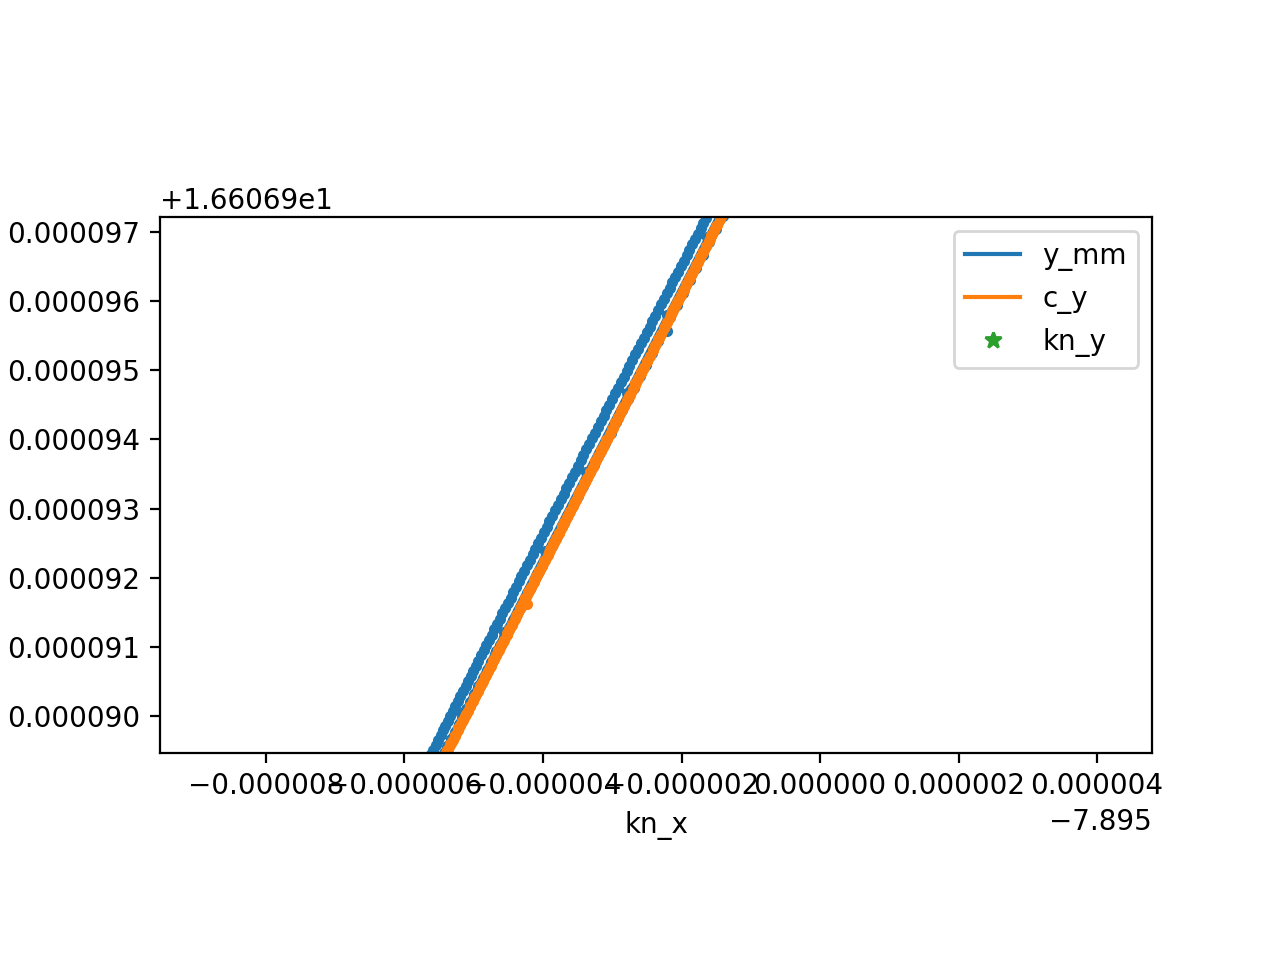

(-12.61813684669413,
 19.251675755959205,
 -13.81381492661832,
 18.055997676035016)

In [86]:
df_emu["x_mm"] = df_emu["apg0_x"]
df_emu["y_mm"] = df_emu["apg2_x"]
last_t = df_emu["t"].iloc[-1]
orig_n = int(last_t * 1000)
print(orig_n)


knots = c.knots()[0]
res3 = c(knots)
df2 = pd.DataFrame()
df2["kn_x"] = res3[:, 0]
df2["kn_y"] = res3[:, 1]
df2["kn_e"] = res3[:, 2]
df2["t"] = c.knots()[0]
knots_n = np.searchsorted(knots, last_t)

res4 = c(df_emu["t"] + knots[0])
df_emu["c_x"] = res4[:, 0]
df_emu["c_y"] = res4[:, 1]

ax = df_emu.plot(x="x_mm", y="y_mm", style=".-", zorder=1)
df_emu.plot(x="c_x", y="c_y", style=".-", zorder=2, ax=ax)
#df[:orig_n].plot(x="x_smooth", y="y_smooth", style=".-", zorder=2, ax=ax)
df2[:knots_n].plot(x="kn_x", y="kn_y", style="*", ax=ax, zorder=3)
plt.axis("square")